# Problem


It is a sample notebook for illustration purposes only. We recommend including the below cell with important candidate instructions.
You may need to update the OS and package versions based on the current environment.

### Environment
Ubuntu 22.04 LTS which includes **Python 3.9.12** and utilities *curl*, *git*, *vim*, *unzip*, *wget*, and *zip*. There is no *GPU* support.

The IPython Kernel allows you to execute Python code in the Notebook cell and Python console.

### Installing packages
- Run `!mamba list "package_name"` command to check the package installation status. For example,

```python
!mamba list numpy
"""
# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
numpy                     1.21.6           py39h18676bf_0    conda-forge
"""
```

    You can also try importing the package.

- Run the `!mamba install "package_name"` to install a package

### Excluding large files
HackerRank rejects any submission larger than **20MB**. Therefore, you must exclude any large files by adding these to the *.gitignore* file.
You can **Submit** code to validate the status of your submission.

## Introduction

The Occupational Employment and Wage Statistics (OEWS) program produces employment and wage estimates annually for nearly 800 occupations. These estimates are available for the nation as a whole, for individual states, and for metropolitan and nonmetropolitan areas; national occupational estimates for specific industries are also available.

## Problem

The data used in this problem is a subset of the OEWS data, which include the 10-th percentile, 25-th percentile, 50-th percentile (a.k.a median), 75-th percentile, and 90-th percentile of the annual salary of a given combination of states, industries, and occupations.

One needs to use the data in _train.csv_ to train a machine learning model to predict the 10-th, 25-th, 50-th, 75-th and 90-th percentiles of the given combinations in _submission.csv_.

## Data

### Independent Variables

There are three independent variable columns:
- PRIM_STATE
- NAICS_TITLE
- OCC_TITLE

indicating the state, industry, and occupation.

NOTE:
- In the _PRIM_STATE_ variable, each category indicates a state postal abbreviation (like "_CA_", "_TX_", etc.) or "_U.S_" as the whole United States. When _PRIM_STATE_ is "_U.S_", it means the percentiles are aggregated across all the states.
- In thes _NAICS_TITLE_, each category indicates an industry sector name (like "_Retail Trade_", "_Manufacturing_") or "_Cross-industry_". When _NAICS_TITLE_ is "_Cross-industry_", it means the percentiles are aggregated across all the industries.

### Target Variables

There are 5 dependent (target) variable columns:
- A_PCT10
- A_PCT25
- A_MEDIAN
- A_PCT75
- A_PCT90

indicating the 10-th percentile, 25-th percentile, median, 75-th percentile, 90-th percentile of the annual base salary given the state, industry, and occupation information.

**IMPORTANT**: the percentiles should follow an increasing order. Namely, the 10-th percentile is less than (<) the 25-th percentile, the 25-th percentile is less than (<) the 50-th percentile, etc.

## Deliverables

### Submit a Well commented Jupyter Notebook

Explore the data, make visualizations, and generate new features if required. Make appropriate plots, annotate the notebook with markdowns and explain necessary inferences. A person should be able to read the notebook and understand the steps taken as well as the reasoning behind them. The solution will be graded on the basis of the usage of effective visualizations to convey the analysis and the modeling process.


### Submit _submission.csv_

In the given _submission.csv_, values in the "A_PCT10", "A_PCT25", "A_MEDIAN", "A_PCT75", and "A_PCT90" columns are constants, and you need to replace them with your model predictions.

**IMPORTANT**:
- please do not change the header given in _submission.csv_, or your predictions may not be evaluated correctly.
- Your Jupyter Notebook should be able to generate your submitted predictions.



## Evaluation Metric

The model performance is evaluated by the mean normalized weighted absolute error (MNWAE) defined as the following:
$$ MNWAE = \frac{1}{n} \sum_{i=1}^{n} \sum_{j \in \{10, 25, 50, 75, 90\}} w_j \times \frac{|y_{i,j}-z_{i,j}|}{z_{i,j}}$$
where $y_{i,j}$ and $z_{i,j}$ are the model estimation and the ground truth of the $i$-th row and $j$-th percentile, and
$$ w_{10} = w_{90} = 0.1, $$
$$ w_{25} = w_{75} = 0.2, $$
$$ w_{50} = 0.4 $$

For example, if

actual percentiles = [10000, 30000, 60000, 80000, 100000],

predicted percentiles = [11000, 33000, 54000, 88000, 120000],

normalized weighted absolute error = 0.1*|11000-10000|/10000+0.2*|33000-30000|/30000+0.4*|54000-60000|/60000+0.2*|88000-80000|/80000+0.1*|120000-100000|/100000 = 0.11

**IMPORTANT**: if the predicted percentiles in any row do not follow an increasing order, all the predictions will be considered as invalid.

# Disclaimer

## README

We have two notebooks here. The final version is `sample.ipynb` as I thought it would be better to keep it the same name as it came with. Wonder how HackerRank runtime works!

The other one is `Annual Base Salary Price Prediction.ipynb` which contains all the analysis and experiments that I was doing while working on this task. It is a detailed version with comments, that would help you understand my thought process when I was working on this task.

This file, i.e. `sample.ipynb` is a refined version which only includes the minimal stuff in all the sections that will help us understand and reach the end goal.

# Solution

## Google Drive Setup

In [ ]:
from google.colab import drive
drive.mount("gdrive")

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [ ]:
%cd "/content/gdrive/MyDrive/HackerRank ML/Annual Base Salary Percentile Estimation/problem"

/content/gdrive/MyDrive/HackerRank ML/Annual Base Salary Percentile Estimation/problem


In [ ]:
!pwd

/content/gdrive/MyDrive/HackerRank ML/Annual Base Salary Percentile Estimation/problem


## Setup

In [ ]:
# import necessary libraries

# data wrangling & computations
import numpy as np
import pandas as pd

# plotting
from matplotlib import pyplot as plt
import seaborn as sns

# machine learning related functionality
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder

# deep learning
import tensorflow as tf

In [ ]:
# load the training data
df_train = pd.read_csv('train.csv')
df_train.head()

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,"Arts, Entertainment, and Recreation",Supervisors of Transportation and Material Mov...,32350.0,40200.0,50790.0,62560.0,78520.0
1,US,"Mining, Quarrying, and Oil and Gas Extraction","Sales Representatives, Wholesale and Manufactu...",47860.0,61600.0,87810.0,107460.0,153600.0
2,US,Finance and Insurance,Physical Scientists,59240.0,63050.0,89740.0,126320.0,149070.0
3,US,Administrative and Support and Waste Managemen...,"Architects, Surveyors, and Cartographers",37320.0,47630.0,60550.0,77450.0,98990.0
4,US,Manufacturing,Supervisors of Protective Service Workers,50130.0,63840.0,81770.0,104530.0,133180.0


## Data Analysis

In [ ]:
# let's check the different states in data
df_train["PRIM_STATE"].value_counts()

US    1498
FL      20
WV      19
DC      19
WA      19
SD      18
CO      18
NM      18
ME      18
NC      18
NH      18
DE      18
MI      18
AR      17
KY      17
GA      17
CA      17
MA      17
MN      17
ND      17
MO      17
UT      17
TX      16
AL      16
AZ      16
IL      16
ID      16
LA      16
MT      16
NJ      15
NV      15
NY      15
MS      15
OH      15
MD      15
HI      15
WI      14
IA      14
IN      14
TN      14
RI      14
VT      13
OK      13
CT      13
VA      13
SC      13
WY      13
PA      13
KS      13
AK      12
NE      12
OR      10
Name: PRIM_STATE, dtype: int64

**Observations**
1. All the states are two character words
2. The distribution of states data is not that imbalanced, except when it represents the whole nation

In [ ]:
# what about NAICS_TITLE?

df_train["NAICS_TITLE"].value_counts()

Cross-industry                                                                                                                         885
Federal, State, and Local Government, excluding state and local schools and hospitals and the U.S. Postal Service (OES Designation)     86
Other Services (except Public Administration)                                                                                           85
Health Care and Social Assistance                                                                                                       84
Management of Companies and Enterprises                                                                                                 84
Educational Services                                                                                                                    79
Administrative and Support and Waste Management and Remediation Services                                                                79
Manufacturing              

**Observations**

1. There's surely some imbalance in data of NAICS_TITLE
2. These long names do not have any overlaps. For ex: we do not have entertainment in more than 1 NAICS_TITLE. So those "comma"s and "and"s does not matter

In [ ]:
# what about OCC_TITLE?

df_train["OCC_TITLE"].value_counts()

Legal Occupations                                                           57
Management Occupations                                                      57
Sales and Related Occupations                                               56
Life, Physical, and Social Science Occupations                              56
Office and Administrative Support Occupations                               55
                                                                            ..
Rail Transportation Workers                                                  7
Preschool, Elementary, Middle, Secondary, and Special Education Teachers     6
Postsecondary Teachers                                                       6
Funeral Service Workers                                                      5
Law Enforcement Workers                                                      3
Name: OCC_TITLE, Length: 116, dtype: int64

**Observations**

1. Data in OCC_TITLE is highly unbalanced
2. We do not see any overlapping occupations here

In [ ]:
# how is NAICS_TITLE important if we have OCC_TITLE?
# as OCC_TITLE is highly specific to the job, that should do the task

# let's analyze Cross-industry NAICS_TITLE first

df_train[df_train["NAICS_TITLE"] == "Cross-industry"]["OCC_TITLE"].value_counts()

Management Occupations                              42
Office and Administrative Support Occupations       40
Food Preparation and Serving Related Occupations    40
Architecture and Engineering Occupations            40
Protective Service Occupations                      40
                                                    ..
Life, Physical, and Social Science Technicians       1
Business Operations Specialists                      1
Grounds Maintenance Workers                          1
Tour and Travel Guides                               1
Air Transportation Workers                           1
Name: OCC_TITLE, Length: 92, dtype: int64

**Observations**
1. NAICS_TITLE will prove to be helpful to tackle this inbalance in data. For ex: we do not have much data for "Air Transportation Workers". However, we know it belongs to "Cross-industry" sector. So based on that, we could get an overall idea of salary range for it

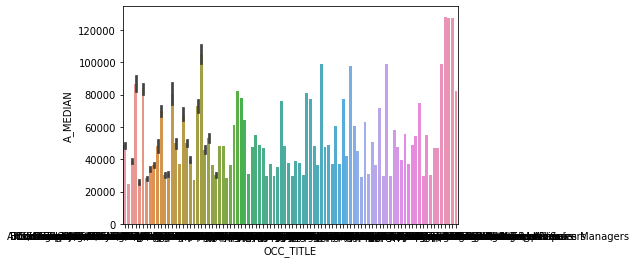

In [ ]:
# let's check the distribution of salary median for this sector

df_cross_industry = df_train[df_train["NAICS_TITLE"] == "Cross-industry"]
sns.barplot(data=df_cross_industry, x="OCC_TITLE", y="A_MEDIAN")

In [ ]:
# as we see a minimum value of 20000 is satisfied by all
# let's see stats as graphs would be hard to visualize for too much data

df_cross_industry.describe()

,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
count,885.000000,885.000000,885.000000,882.000000,847.000000
mean,31762.960452,40095.005650,53241.468927,71343.287982,89526.269185
std,10508.141997,16006.723097,24187.837102,34058.364013,40078.537930
min,17080.000000,17620.000000,18860.000000,23780.000000,29740.000000
25%,23380.000000,29040.000000,36090.000000,46692.500000,60025.000000
50%,29200.000000,36410.000000,47370.000000,61150.000000,78450.000000
75%,37340.000000,48360.000000,64650.000000,95420.000000,121700.000000
max,80480.000000,122510.000000,170690.000000,200770.000000,206960.000000


**Observations**
1. We get a min max bound
2. This could help to predict for "Air Transportation Workers" as we do not have much data about it

In [ ]:
# let's check if something similar is the case

df_cross_industry[df_cross_industry["OCC_TITLE"]=="Air Transportation Workers"]

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
2164,US,Cross-industry,Air Transportation Workers,39450.0,60520.0,82170.0,158870.0,NaN


**Observations**
1. All the values are post 75%tile. Atleast this pattern would help us get a little accuracy as compared to random prediction. Which implies that the sector feature is important.

**Till now, we have known that all the three features are important**

In [ ]:
# now let's check if there are patterns within these columns itself

# for PRIM_STATE

df_state = df_train.groupby(["PRIM_STATE"]).agg(
              avg_10=("A_PCT10", "mean"),
              med_10=("A_PCT10", "median"),
              avg_25=("A_PCT25", "mean"),
              med_25=("A_PCT25", "median"),
              avg_50=("A_MEDIAN", "mean"),
              med_50=("A_MEDIAN", "median"),
              avg_75=("A_PCT75", "mean"),
              med_75=("A_PCT75", "median"),
              avg_90=("A_PCT90", "mean"),
              med_90=("A_PCT90", "median"),
          )
df_state

,avg_10,med_10,avg_25,med_25,avg_50,med_50,avg_75,med_75,avg_90,med_90
PRIM_STATE,,,,,,,,,,
AK,36665.833333,37540.0,46935.000000,47660.0,63078.333333,61770.0,83341.666667,79910.0,110769.166667,101870.0
AL,29546.875000,27820.0,37513.750000,33245.0,49845.625000,42060.0,68768.750000,59640.0,89927.500000,70925.0
AR,27882.941176,23710.0,34021.176471,29720.0,44990.000000,37650.0,60521.176471,48060.0,83147.058824,62940.0
AZ,32472.500000,29345.0,38340.625000,33770.0,50604.375000,47250.0,66711.875000,60330.0,91445.625000,76825.0
CA,38533.529412,33470.0,47632.941176,38890.0,65309.411765,58690.0,91274.117647,78820.0,104690.666667,100510.0
CO,35481.111111,30515.0,43912.222222,38345.0,57287.777778,49700.0,77589.444444,63275.0,88734.375000,80030.0
CT,38418.461538,30810.0,49321.538462,39420.0,66716.153846,60970.0,89805.384615,77640.0,98720.909091,97760.0
DC,43837.368421,37070.0,57544.736842,47630.0,76042.631579,62080.0,93373.888889,79945.0,116310.588235,101780.0
DE,34504.444444,29220.0,44625.555556,37660.0,59930.555556,48420.0,82852.222222,65140.0,92374.375000,86670.0


In [ ]:
# sort by avg_10 to see if what pattern exists
df_state.sort_values(by=["avg_10"], axis=0, inplace=True)
df_state

,avg_10,med_10,avg_25,med_25,avg_50,med_50,avg_75,med_75,avg_90,med_90
PRIM_STATE,,,,,,,,,,
MS,24181.333333,22620.0,29730.000000,28500.0,39377.333333,36560.0,52886.666667,46910.0,69038.000000,60040.0
WV,24291.052632,22700.0,30406.842105,29010.0,39687.894737,37370.0,52370.000000,48370.0,70353.684211,61330.0
LA,24390.000000,22545.0,31810.625000,28980.0,42896.875000,41520.0,56589.375000,57330.0,73841.250000,69500.0
KY,25817.058824,23550.0,32526.470588,29180.0,42372.941176,36760.0,57501.764706,47310.0,75114.117647,60460.0
OK,26142.307692,22940.0,34382.307692,29460.0,44356.153846,38370.0,62181.538462,52040.0,84596.153846,75880.0
SC,26443.846154,23270.0,32753.846154,30020.0,42322.307692,38550.0,57157.692308,49390.0,77083.076923,63340.0
ID,27056.250000,23730.0,34826.250000,30385.0,47637.500000,45640.0,62361.250000,54940.0,81894.375000,69405.0
NV,27257.333333,23950.0,35178.666667,29910.0,46008.000000,38980.0,61444.666667,61190.0,82489.333333,78550.0
MO,27749.411765,24910.0,35072.941176,30160.0,46052.352941,41510.0,60885.294118,49630.0,82365.882353,76750.0


**Observations**
1. There are clusters of states that we see. Basically, two states in the same cluster will tend to have similar salaries, though with a little variance.

In [ ]:
# there are certain states which do not follow the monotously increasing pattern
# accuracy with those states might be low, in the case where sector and occuption are too not having a strong correlation with target

# list of those states
df_check_monotonous_pattern = (df_state.diff(1)*100) / df_state

# set 5% threshold as such smaller drops might happen when being affected by external factors
((df_check_monotonous_pattern < 0) & (abs(df_check_monotonous_pattern) > 5)).any(axis=1)

PRIM_STATE
MS    False
WV    False
LA    False
KY     True
OK    False
SC     True
ID    False
NV     True
MO     True
UT    False
AR     True
GA    False
KS     True
IA     True
FL    False
IN     True
MT     True
NC     True
WY    False
OH     True
AL     True
TN     True
TX     True
WI     True
NM    False
PA     True
VT     True
MI     True
VA     True
SD     True
ND    False
AZ     True
IL     True
MN     True
NE     True
DE     True
NH     True
ME     True
HI    False
US     True
CO    False
OR    False
NJ     True
AK    False
NY     True
RI     True
MD    False
CT     True
CA    False
MA     True
WA    False
DC    False
dtype: bool

**Observations**
1. There's no such monotonous pattern
2. We could use df_state as the state's feature vectors when training a model
3. Clustering states might be useless then, as we already have the state itself and some derived features of it.

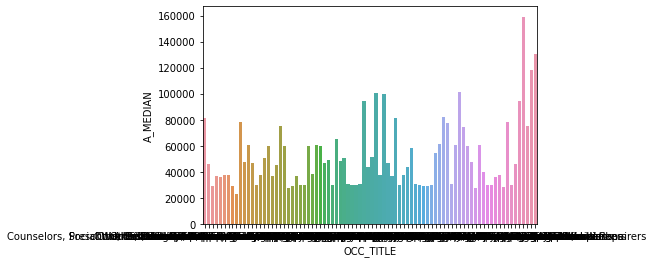

In [ ]:
# now, let's see how different occupations from the same sector related to each other
# is there some pattern within?

# both the below services seem to be a good choice for such analysis, as we have more datapoints to derive conclusions
# 1. Health Care and Social Assistance
# 2. Management of Companies and Enterprises

# for health care
df_health_care = df_train[df_train['NAICS_TITLE'] == "Health Care and Social Assistance"]
sns.barplot(data=df_health_care, x="OCC_TITLE", y="A_MEDIAN")

**Observations**
1. NAICS_TITLE defines a bare minimum for all the jobs in the industry

### Outlier Analysis

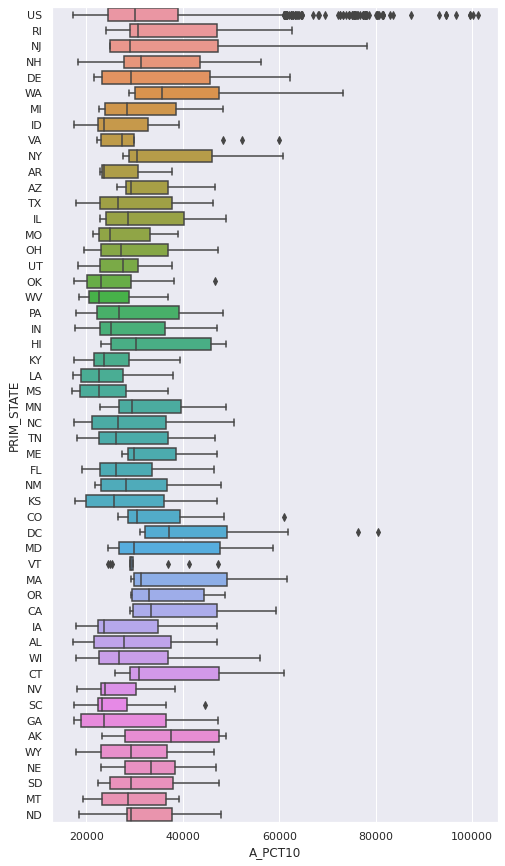

In [ ]:
# let's visualize the target variables now and check for outliers

# enlarge plot as needed
sns.set(rc={'figure.figsize':(8,15)})

sns.boxplot(data=df_train, x="A_PCT10", y="PRIM_STATE")

**Observations**
1. Box plot identifies many more outliers in the US state. Cbiovusly, beacuse it is having country wide data so that's possible.
2. Something is wrong with the data of states "VT", "VA" and "DC"?. Why are they having outliers.

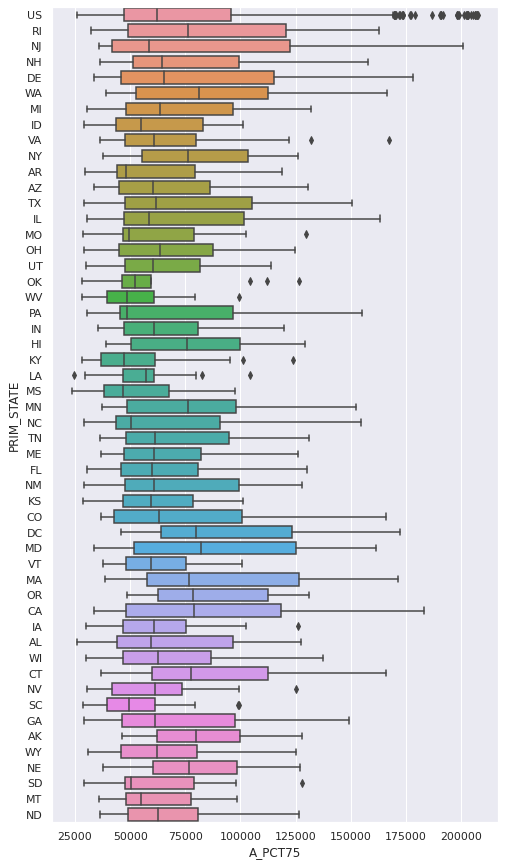

In [ ]:
# let's check the same for other target variables first

sns.boxplot(data=df_train, x="A_PCT75", y="PRIM_STATE")

**Observations**
1. Seems like OK and KY should be added to the list
2. Final list of states that may contain outlier data: US (to be neglected), VA, VT, OK, KY

In [ ]:
# what's wrong? are these jobs very unique or highly common?
# let's check

possible_outlier_states = ["VA", "VT", "OK", "KY"]
for state in possible_outlier_states:
  df_temp = df_train[df_train["PRIM_STATE"] == state]
  q1 = df_temp["A_MEDIAN"].quantile(0.25)
  q3 = df_temp["A_MEDIAN"].quantile(0.75)
  iqr = q3 - q1
  upper_limit = q3 + iqr
  print("Possible outlier data for", state)
  print(df_temp[df_temp["A_MEDIAN"] > upper_limit])

Possible outlier data for VA
     PRIM_STATE     NAICS_TITLE                                 OCC_TITLE  \
45           VA  Cross-industry  Architecture and Engineering Occupations   
222          VA  Cross-industry     Computer and Mathematical Occupations   
2282         VA  Cross-industry                    Management Occupations   

      A_PCT10  A_PCT25  A_MEDIAN   A_PCT75   A_PCT90  
45    48280.0  62570.0   88230.0  122000.0  161040.0  
222   52320.0  77910.0  101680.0  131780.0  166160.0  
2282  60010.0  81080.0  126340.0  167440.0       NaN  
Possible outlier data for VT
     PRIM_STATE     NAICS_TITLE  \
700          VT  Cross-industry   
1009         VT  Cross-industry   
1331         VT  Cross-industry   

                                              OCC_TITLE  A_PCT10  A_PCT25  \
700               Computer and Mathematical Occupations  47370.0  60360.0   
1009  Healthcare Practitioners and Technical Occupat...  36910.0  49610.0   
1331      Business and Financial Operatio

**Observations**
1. As we see, most of them belong to one of these:
  - Computer and Mathematical Occupations
  - Business and Financial Operations Occupations
  - Architecture and Engineering Occupations
  - Management Occupations

2. There might be two more cases here, where we should not consider them as outliers:
  - Either, these jobs have less supply of qualified workforce in these states
  - Or, these jobs are highly paid in other states as well, and there is sufficient data of these jobs for these states

In [ ]:
# but let's check something that I doubt first..
df_train[df_train["OCC_TITLE"] == "Computer and Mathematical Occupations"]["NAICS_TITLE"].value_counts()

Cross-industry                                                                                                                         38
Accommodation and Food Services                                                                                                         1
Manufacturing                                                                                                                           1
Administrative and Support and Waste Management and Remediation Services                                                                1
Agriculture, Forestry, Fishing and Hunting                                                                                              1
Professional, Scientific, and Technical Services                                                                                        1
Management of Companies and Enterprises                                                                                                 1
Educational Services              

***Gotcha! At first, I thought that an occupation can belong to only one sector, but it's not the case***

**Observations**
1. All the possible outlier data printed above belongs to the "Cross-industry" category which makes me strongly believe that those points are not outliers

**Conclusions**
1. We cannot remove the cross-industry value by marking all other industries as 1 after one hot encoding. The same would apply to the US value in state column.

In [ ]:
# let's focus on the supply of workforce for now

possible_outlier_states = ["VA", "VT", "OK", "KY"]
for state in possible_outlier_states:
  df_temp = df_train[df_train["PRIM_STATE"] == state]
  q1 = df_temp["A_MEDIAN"].quantile(0.25)
  q3 = df_temp["A_MEDIAN"].quantile(0.75)
  iqr = q3 - q1
  upper_limit = q3 + iqr
  df_possible_outlier_temp = df_temp[df_temp["A_MEDIAN"] > upper_limit]

  for idx, row in df_possible_outlier_temp.iterrows():
    total_job_in_the_city = len(df_temp[df_temp["OCC_TITLE"] == row["OCC_TITLE"]])
    print("Total", total_job_in_the_city, "entry for", row["OCC_TITLE"], "in the state", row["PRIM_STATE"], "found")

Total 1 entry for Architecture and Engineering Occupations in the state VA found
Total 1 entry for Computer and Mathematical Occupations in the state VA found
Total 1 entry for Management Occupations in the state VA found
Total 1 entry for Computer and Mathematical Occupations in the state VT found
Total 1 entry for Healthcare Practitioners and Technical Occupations in the state VT found
Total 1 entry for Business and Financial Operations Occupations in the state VT found
Total 1 entry for Legal Occupations in the state OK found
Total 1 entry for Management Occupations in the state OK found
Total 1 entry for Architecture and Engineering Occupations in the state OK found
Total 1 entry for Management Occupations in the state KY found
Total 1 entry for Architecture and Engineering Occupations in the state KY found


**Observations**
1. There wasn't enough data to justify them as outliers

In [ ]:
# let's check if these values are justified in US

# for Architecture and Engineering Occupations
# copying values from above output cells for easy comparision
# 48280.0  62570.0   88230.0  122000.0  161040.0
# 46640.0  60710.0   78270.0  104120.0  146040.0
# 39120.0  49800.0   73060.0   95300.0  119770.0

df_train[df_train["OCC_TITLE"] == "Architecture and Engineering Occupations"].describe()

,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
count,53.000000,53.000000,53.000000,53.000000,53.000000
mean,46874.905660,61700.188679,82856.037736,107740.000000,135721.320755
std,7180.395485,8721.098090,9806.637732,14284.896408,17436.748334
min,36440.000000,46690.000000,70360.000000,80020.000000,98690.000000
25%,39270.000000,58770.000000,76980.000000,99310.000000,126780.000000
50%,47210.000000,60710.000000,78230.000000,101120.000000,129310.000000
75%,48660.000000,62570.000000,91210.000000,122000.000000,151140.000000
max,61790.000000,79570.000000,114050.000000,150070.000000,172490.000000


**Observations**
1. These data points are justified by the data of occupation

**Conclusions**
1. I do not see any outliers in data. The points that seem to be outlier are justified by lack of data and support by other states for the same occupation.
2. No outliers to remove. (Let's cross check)

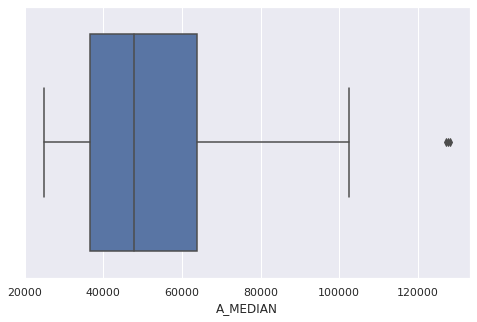

In [ ]:
# let's simply visualize US for cross sector
sns.set(rc={'figure.figsize':(8,5)})
df_temp = df_train[(df_train["PRIM_STATE"] == "US") & (df_train["NAICS_TITLE"] == "Cross-industry")]
sns.boxplot(data=df_temp, x="A_MEDIAN")  

**Conclusions**
1. Not much outliers to remove.

### Handle Missing Data

In [ ]:
# let's check for and handle nans first

df_train.isna().any()

PRIM_STATE     False
NAICS_TITLE    False
OCC_TITLE      False
A_PCT10        False
A_PCT25        False
A_MEDIAN       False
A_PCT75         True
A_PCT90         True
dtype: bool

In [ ]:
# percentage of missing information

(df_train.isna().sum()*100) / len(df_train)

PRIM_STATE     0.000000
NAICS_TITLE    0.000000
OCC_TITLE      0.000000
A_PCT10        0.000000
A_PCT25        0.000000
A_MEDIAN       0.000000
A_PCT75        1.306051
A_PCT90        6.051371
dtype: float64

**Observations**
1. Around 6-7% of data is missing. The first thought would be to drop them but let's think statistically if we should drop them.

In [ ]:
# we have three categorical columns that create a unique combination when combined
# so the total combinations possible in the dataaset can be
total_permutations = len(df_train["PRIM_STATE"].unique()) * len(df_train["NAICS_TITLE"].unique()) * len(df_train["OCC_TITLE"].unique())

# the above is not the correct way.. as I am not considering domain knowledge here. A few occupations can never belong to an industry. And a few industries can't exist in a few states.

# and we just have a % of it
(len(df_train)*100) / total_permutations

1.8133447012757358

**Observations**
1. Our data already lacks a lot of information. We just have 1.81% of total information. Let's not focus on dropping nans


There's a way to fill it. We could use mean/median values of the state or of the industry or we could simply fill in the values from US and Cross-industry (as they are anyway generic and covering everything).

Let's see what could happen.


In [ ]:
# let's look at some rows containing nan

df_nans = df_train[df_train.isna().any(axis=1)]
df_nans

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
2158,US,Cross-industry,Management Occupations,47860.0,74710.0,102450.0,160960.0,NaN
2159,US,Cross-industry,Top Executives,41260.0,60900.0,98720.0,160540.0,NaN
2160,US,Cross-industry,"Advertising, Marketing, Promotions, Public Rel...",63270.0,95140.0,128160.0,177360.0,NaN
2161,US,Cross-industry,Operations Specialties Managers,73230.0,95660.0,127140.0,165860.0,NaN
2162,US,Cross-industry,Legal Occupations,38620.0,58400.0,82430.0,156900.0,NaN
...,...,...,...,...,...,...,...,...
2292,NJ,Cross-industry,Legal Occupations,47950.0,73720.0,101550.0,163990.0,NaN
2293,NY,Cross-industry,Legal Occupations,47580.0,75920.0,126220.0,NaN,NaN
2294,RI,Cross-industry,Legal Occupations,46400.0,60560.0,98070.0,161120.0,NaN
2295,TX,Cross-industry,Legal Occupations,37540.0,51260.0,80850.0,135490.0,NaN


In [ ]:
df_nans["PRIM_STATE"].value_counts()

US    108
NJ      3
RI      2
CO      2
CT      2
DE      2
DC      2
IL      2
MA      2
CA      2
NY      2
TX      2
WA      1
VA      1
NH      1
PA      1
NC      1
MD      1
GA      1
FL      1
Name: PRIM_STATE, dtype: int64

In [ ]:
df_nans["NAICS_TITLE"].value_counts()

Cross-industry                                                                                                                         38
Finance and Insurance                                                                                                                  12
Mining, Quarrying, and Oil and Gas Extraction                                                                                          10
Wholesale Trade                                                                                                                         9
Management of Companies and Enterprises                                                                                                 9
Information                                                                                                                             8
Professional, Scientific, and Technical Services                                                                                        7
Manufacturing                     

In [ ]:
df_nans["OCC_TITLE"].value_counts()

Legal Occupations                                                           29
Management Occupations                                                      27
Lawyers, Judges, and Related Workers                                        18
Top Executives                                                              13
Advertising, Marketing, Promotions, Public Relations, and Sales Managers    13
Operations Specialties Managers                                             12
Other Management Occupations                                                 7
Air Transportation Workers                                                   6
Physical Scientists                                                          3
Life Scientists                                                              2
Healthcare Diagnosing or Treating Practitioners                              2
Engineers                                                                    1
Supervisors of Sales Workers                        

In [ ]:
# let's just get one row to deduce some logic for filling nans

df_nan_sample = df_nans.iloc[0]
df_nan_sample

PRIM_STATE                         US
NAICS_TITLE            Cross-industry
OCC_TITLE      Management Occupations
A_PCT10                       47860.0
A_PCT25                       74710.0
A_MEDIAN                     102450.0
A_PCT75                      160960.0
A_PCT90                           NaN
Name: 2158, dtype: object

In [ ]:
# do we have any other data for this occupation?

df_occ_management = df_train[df_train["OCC_TITLE"] == "Management Occupations"]
df_occ_management.shape

(57, 8)

In [ ]:
# lots of data gere
# let's check it's distribution

# values from above are bluntly copied here for easy comparision
# A_PCT10                       47860.0
# A_PCT25                       74710.0
# A_MEDIAN                     102450.0
# A_PCT75                      160960.0
# A_PCT90                           NaN


df_occ_management.describe()

,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
count,57.000000,57.0000,57.000000,55.000000,30.000000
mean,52491.929825,74620.0000,106666.315789,145855.272727,176391.666667
std,12307.439306,17443.3439,22855.329922,27200.731666,19336.184961
min,32760.000000,46480.0000,59700.000000,77940.000000,116630.000000
25%,46400.000000,60900.0000,94530.000000,126690.000000,164797.500000
50%,48250.000000,74460.0000,99340.000000,137630.000000,168360.000000
75%,60900.000000,85720.0000,126340.000000,165245.000000,190495.000000
max,80480.000000,122510.0000,160540.000000,206950.000000,207490.000000


**Observations**
1. There doesn't seem to be any pattern between the available occupation data and the missing one, with which we can fill in missing information.


Let's try with a new idea


If we get the distribution of the difference between PCT90 and PCT75, for the values that we have, then we might be able to find something useful.


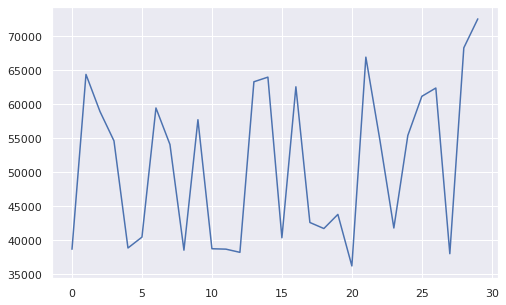

In [ ]:
df_diff_90_75 = df_occ_management["A_PCT90"] - df_occ_management["A_PCT75"]
df_diff_90_75.reset_index(drop=True).plot()

In [ ]:
# its completely random, seems like we can add up the mean value

((df_diff_90_75*100) / df_occ_management["A_PCT75"]).describe()

count    30.000000
mean     41.239514
std       9.586883
min      28.906624
25%      31.568683
50%      42.360394
75%      49.495289
max      59.150389
dtype: float64

In [ ]:
# check if all the 90s are too nan where 75s are nan
df_train[df_train["A_PCT75"].isna()]["A_PCT90"].sum()

0.0

**Observations**
1. Everywhere PCT75 is missing, PCT90 is also missing, which was expected.

**To consider**
We should avoid filling in the mis-information. That could possibly be prevented by preventing the filling process when variance of supporting data is too high.  

In [ ]:
df_train_filled = df_train.copy()

# we shouldn't fill values with huge uncertainity.. so if the standard deviation is too high, we do not fill with the mean, and drop instead
idxs_to_drop = []

for occ_title, group in df_train_filled[df_train_filled["A_PCT75"].isna()].groupby(["OCC_TITLE"]):
  df_occ = df_train[df_train["OCC_TITLE"] == occ_title]
  if len(group) < len(df_occ):
    df_diff_75_50 = df_occ["A_PCT75"] - df_occ["A_MEDIAN"]
    df_diff_75_50_per = (df_diff_75_50*100) / df_occ["A_MEDIAN"]

    if (df_diff_75_50_per.mean() / 2.5) >= df_diff_75_50_per.std():
      df_train_filled.loc[group.index, "A_PCT75"] = df_train_filled.loc[group.index, "A_MEDIAN"] + df_diff_75_50.mean()

      
    else:
      idxs_to_drop.extend(group.index)
  else:
      idxs_to_drop.extend(group.index)

In [ ]:
# summary

df_train_filled.isna().sum(), df_train.isna().sum(), len(idxs_to_drop)

(PRIM_STATE       0
 NAICS_TITLE      0
 OCC_TITLE        0
 A_PCT10          0
 A_PCT25          0
 A_MEDIAN         0
 A_PCT75          2
 A_PCT90        139
 dtype: int64, PRIM_STATE       0
 NAICS_TITLE      0
 OCC_TITLE        0
 A_PCT10          0
 A_PCT25          0
 A_MEDIAN         0
 A_PCT75         30
 A_PCT90        139
 dtype: int64, 2)

In [ ]:
# let's repeat the same for PCT90

for occ_title, group in df_train_filled[df_train_filled["A_PCT90"].isna()].groupby(["OCC_TITLE"]):
  df_occ = df_train[df_train["OCC_TITLE"] == occ_title]
  if len(group) < len(df_occ):
    df_diff_90_75 = df_occ["A_PCT90"] - df_occ["A_PCT75"]
    df_diff_90_75_per = (df_diff_90_75*100) / df_occ["A_PCT75"]

    if (df_diff_90_75_per.mean() / 2.5) >= df_diff_90_75_per.std():
      df_train_filled.loc[group.index, "A_PCT90"] = df_train_filled.loc[group.index, "A_PCT75"] + df_diff_90_75.mean()
      
    else:
      idxs_to_drop.extend(group.index)
  else:
      idxs_to_drop.extend(group.index)

In [ ]:
# summary
df_train_filled.isna().sum(), df_train.isna().sum(), len(idxs_to_drop)

(PRIM_STATE      0
 NAICS_TITLE     0
 OCC_TITLE       0
 A_PCT10         0
 A_PCT25         0
 A_MEDIAN        0
 A_PCT75         2
 A_PCT90        36
 dtype: int64, PRIM_STATE       0
 NAICS_TITLE      0
 OCC_TITLE        0
 A_PCT10          0
 A_PCT25          0
 A_MEDIAN         0
 A_PCT75         30
 A_PCT90        139
 dtype: int64, 37)

In [ ]:
# let's save the new data for future

df_train_filled.drop(list(set(idxs_to_drop)), inplace=True)
df_train_filled.isna().sum()

PRIM_STATE     0
NAICS_TITLE    0
OCC_TITLE      0
A_PCT10        0
A_PCT25        0
A_MEDIAN       0
A_PCT75        0
A_PCT90        0
dtype: int64

In [ ]:
df_train_filled.shape

(2261, 8)

In [ ]:
df_train_filled.to_csv("train_fillna.csv")

## Baseline Modelling - Random Forest

Random Forest would be my first pick for baseline because it is capable of branching based on conditions of categorical features. Howwever, it is not expected to be that optimial as is lacks the power of training using gradient descent.

### Predict all targets at once

#### Feature Engineering

In [ ]:
# let's start by training a random forest
# we will have to encode the categorical features
# using one-hot encoding

ohe = OneHotEncoder(categories="auto")
feature_arr = ohe.fit_transform(df_train_filled[["PRIM_STATE", "NAICS_TITLE", "OCC_TITLE"]]).toarray()
feature_labels = ohe.categories_

df_dummies = pd.DataFrame(feature_arr, columns=feature_labels[0].tolist() + feature_labels[1].tolist() + feature_labels[2].tolist())
df_dummies

# df_dummies = pd.get_dummies(df_train_filled[["PRIM_STATE", "NAICS_TITLE", "OCC_TITLE"]], drop_first=False)
# df_dummies

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,Supervisors of Protective Service Workers,Supervisors of Sales Workers,Supervisors of Transportation and Material Moving Workers,"Textile, Apparel, and Furnishings Workers",Top Executives,Tour and Travel Guides,Transportation and Material Moving Occupations,"Vehicle and Mobile Equipment Mechanics, Installers, and Repairers",Water Transportation Workers,Woodworkers
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_x = df_dummies.copy()
df_y = df_train_filled[[col for col in df_train_filled.columns if "A_" in col]]
df_y

,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,32350.0,40200.0,50790.0,62560.0,78520.000000
1,47860.0,61600.0,87810.0,107460.0,153600.000000
2,59240.0,63050.0,89740.0,126320.0,149070.000000
3,37320.0,47630.0,60550.0,77450.0,98990.000000
4,50130.0,63840.0,81770.0,104530.0,133180.000000
...,...,...,...,...,...
2291,49430.0,63500.0,104280.0,171230.0,223628.571429
2292,47950.0,73720.0,101550.0,163990.0,216388.571429
2293,47580.0,75920.0,126220.0,178048.0,230446.571429
2294,46400.0,60560.0,98070.0,161120.0,213518.571429


#### Training & Evaluation

Let's just ignore the pattern in target columns for now and train a random forest.

We have to have a train-test split. However, there's not distribution in the X (features) to have a strategic split, except the pattern that which occupations go with which industry.


Also, we cannot have any ideal test set in our case so we will go with k-fold methology to training.

In [ ]:
# let's define our loss functions

def normalized_absolute_error(true, pred):
    return abs(pred - true) / true

def mean_normalized_weighted_absolute_error(y_true, y_pred):
  # the shape of ys must be (batch_size, 5) as we have 5 targets  
  # todo: incorporate the order of predected precentiles and return 0 if the order is not followed
  
  # weighted error calcluation
  l10 = 0.1*normalized_absolute_error(y_true[:, 0], y_pred[:, 0])
  l25 = 0.2*normalized_absolute_error(y_true[:, 1], y_pred[:, 1])
  l50 = 0.4*normalized_absolute_error(y_true[:, 2], y_pred[:, 2])
  l75 = 0.2*normalized_absolute_error(y_true[:, 3], y_pred[:, 3])
  l90 = 0.1*normalized_absolute_error(y_true[:, 4], y_pred[:, 4])

  # return mean
  return (l10+l25+l50+l75+l90).mean()

In [ ]:
# let's directly train a random forest which predicts all the 5 targets at once

rf_reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=50,
    max_leaf_nodes=25,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
)
cv = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)

scores = []
mnwae_scores = []

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
    rf_reg.fit(df_x.iloc[train].values, df_y.iloc[train].values)
    
    train_score = rf_reg.score(df_x.iloc[train].values, df_y.iloc[train].values)
    test_score = rf_reg.score(df_x.iloc[test].values, df_y.iloc[test].values)
    scores.append((train_score, test_score))

    y_pred = rf_reg.predict(df_x.iloc[train].values)
    train_score = mean_normalized_weighted_absolute_error(df_y.iloc[train].values, y_pred)
    
    y_pred = rf_reg.predict(df_x.iloc[test].values)
    test_score = mean_normalized_weighted_absolute_error(df_y.iloc[test].values, y_pred)

    mnwae_scores.append((train_score, test_score))


print(scores)
print(mnwae_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


[(0.663364912411119, 0.6046403979499047), (0.6575663437516909, 0.6359270868604653), (0.6599182906212955, 0.610396237688526), (0.6581258393389267, 0.6324624084130538)]
[(0.22782709818879243, 0.2328146815331187), (0.22707447618600282, 0.23955948484091183), (0.22887312228046516, 0.23636010420870704), (0.23146527405270154, 0.23099945418854068)]


In [ ]:
# changing a few hyper params

rf_reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=25,
    max_leaf_nodes=50,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
)
cv = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)

scores = []
mnwae_scores = []

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
    rf_reg.fit(df_x.iloc[train].values, df_y.iloc[train].values)
    
    train_score = rf_reg.score(df_x.iloc[train].values, df_y.iloc[train].values)
    test_score = rf_reg.score(df_x.iloc[test].values, df_y.iloc[test].values)
    scores.append((train_score, test_score))

    y_pred = rf_reg.predict(df_x.iloc[train].values)
    train_score = mean_normalized_weighted_absolute_error(df_y.iloc[train].values, y_pred)
    
    y_pred = rf_reg.predict(df_x.iloc[test].values)
    test_score = mean_normalized_weighted_absolute_error(df_y.iloc[test].values, y_pred)

    mnwae_scores.append((train_score, test_score))


print(scores)
print(mnwae_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


[(0.7247090800434977, 0.6256745122821659), (0.7251708393511714, 0.6573278408194753), (0.730914677741851, 0.6444473236284397), (0.7255074940493145, 0.6417742397209698)]
[(0.2040076601811786, 0.2162682796625576), (0.20077752278909244, 0.21951915397687596), (0.20286027968021955, 0.2129044008603857), (0.20388768310508384, 0.21228140092066053)]


**Observations**
1. A random forest which predicts all the five targets at once, gives around 0.22 *mean normalized weighted absolute error*, without incorporating the orders of targets.

#### Visualization

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


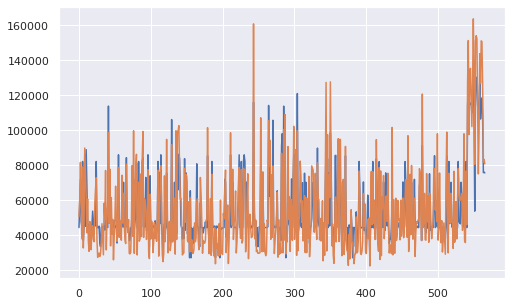

In [ ]:
# atleast we have some baseline now, let's visualize the output
y_pred = None
y_true = None

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):    
    y_pred = rf_reg.predict(df_x.iloc[test].values)
    y_true = df_y.iloc[test].values
    break

plt.plot(range(len(y_pred)), y_pred[:, 2])
plt.plot(range(len(y_true)), y_true[:, 2])

### Predict a target at a time

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


[(0.7544073293010194, 0.6408782628014631), (0.751210581024368, 0.6757712923514246), (0.7538676839889218, 0.650265870558544), (0.7541897929876049, 0.6402343463395656)]
[(0.19999763038563617, 0.21067893491689257), (0.19451404190655963, 0.2138426187532167), (0.19827526275523236, 0.210766350496602), (0.19903766323020605, 0.2098207659821865)]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


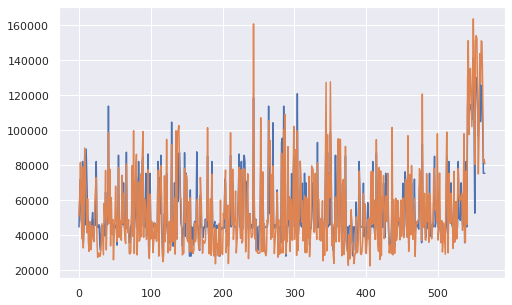

In [ ]:
# let's just train the model to predict MEDIAN instead of all targets and see what happens

rf_reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=25,
    max_leaf_nodes=50,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
)
cv = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)


scores = []
mape_scores = []

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
    rf_reg.fit(df_x.iloc[train].values, df_y.iloc[train]["A_MEDIAN"].values)
    
    train_score = rf_reg.score(df_x.iloc[train].values, df_y.iloc[train]["A_MEDIAN"].values)
    test_score = rf_reg.score(df_x.iloc[test].values, df_y.iloc[test]["A_MEDIAN"].values)
    scores.append((train_score, test_score))


    y_pred = rf_reg.predict(df_x.iloc[train].values)
    train_score = mean_absolute_percentage_error(df_y.iloc[train]["A_MEDIAN"].values, y_pred)
    
    y_pred = rf_reg.predict(df_x.iloc[test].values)
    test_score = mean_absolute_percentage_error(df_y.iloc[test]["A_MEDIAN"].values, y_pred)
    mape_scores.append((train_score, test_score))


print(scores)
print(mape_scores)

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
  y_pred = rf_reg.predict(df_x.iloc[test].values)
  y_true = df_y.iloc[test]["A_MEDIAN"].values
  break

plt.plot(range(len(y_pred)), y_pred, label="pred")
plt.plot(range(len(y_true)), y_true, label="true")

**Observations**
1. A random forest which predicts one targets at a time, gives around 0.22 *mean absolute error*, without incorporating the orders of targets.

## Training a DNN

### Feature Engineering

In [ ]:
# let's work on getting some features as input instead of one hot encoding

# remember this feature vector that we built above during analysis? we will use the same here
# basically these features are mere statistical information about the state's salary
# for PRIM_STATE

df_state = df_train_filled.groupby(["PRIM_STATE"]).agg(
              min_10=("A_PCT10", "min"),
              avg_10=("A_PCT10", "mean"),
              med_10=("A_PCT10", "median"),
              max_10=("A_PCT10", "max"),
              min_25=("A_PCT25", "min"),
              avg_25=("A_PCT25", "mean"),
              med_25=("A_PCT25", "median"),
              max_25=("A_PCT25", "max"),
              min_50=("A_MEDIAN", "min"),
              avg_50=("A_MEDIAN", "mean"),
              med_50=("A_MEDIAN", "median"),
              max_50=("A_MEDIAN", "max"),
              min_75=("A_PCT75", "min"),
              avg_75=("A_PCT75", "mean"),
              med_75=("A_PCT75", "median"),
              max_75=("A_PCT75", "max"),
              min_90=("A_PCT90", "min"),
              avg_90=("A_PCT90", "mean"),
              med_90=("A_PCT90", "median"),
              max_90=("A_PCT90", "max"))

# used later during prediction
df_state_final = df_state.copy()

df_state

,min_10,avg_10,med_10,max_10,min_25,avg_25,med_25,max_25,min_50,avg_50,med_50,max_50,min_75,avg_75,med_75,max_75,min_90,avg_90,med_90,max_90
PRIM_STATE,,,,,,,,,,,,,,,,,,,,
AK,23190.0,36665.833333,37540.0,49010.0,28240.0,46935.000000,47660.0,68840.0,30720.0,63078.333333,61770.0,98810.0,46210.0,83341.666667,79910.0,127830.0,60830.0,110769.166667,101870.0,168290.000000
AL,17290.0,29546.875000,27820.0,47040.0,17920.0,37513.750000,33245.0,62790.0,20690.0,49845.625000,42060.0,94650.0,26020.0,68768.750000,59640.0,127400.0,31180.0,89927.500000,70925.0,182160.000000
AR,22880.0,27882.941176,23710.0,37740.0,23010.0,34021.176471,29720.0,49120.0,23870.0,44990.000000,37650.0,77150.0,29530.0,60521.176471,48060.0,119020.0,37700.0,83147.058824,62940.0,163170.000000
AZ,26400.0,32472.500000,29345.0,46750.0,28350.0,38340.625000,33770.0,61660.0,29280.0,50604.375000,47250.0,97920.0,33470.0,66711.875000,60330.0,130630.0,41460.0,91445.625000,76825.0,191790.000000
CA,29120.0,38533.529412,33470.0,59360.0,29400.0,47632.941176,38890.0,79800.0,29740.0,65309.411765,58690.0,126830.0,33510.0,91274.117647,78820.0,183290.0,43590.0,119579.915966,101590.0,235688.571429
CO,26490.0,35481.111111,30515.0,60970.0,28390.0,43912.222222,38345.0,88380.0,29910.0,57287.777778,49700.0,126460.0,36590.0,77589.444444,63275.0,165820.0,47820.0,102401.587302,89230.0,217060.000000
CT,25920.0,38418.461538,30810.0,60900.0,28080.0,49321.538462,39420.0,85570.0,29340.0,66716.153846,60970.0,125770.0,36650.0,89805.384615,77640.0,165860.0,47960.0,115902.197802,98720.0,217100.000000
DC,31200.0,43837.368421,37070.0,80480.0,31220.0,57544.736842,47630.0,122510.0,35530.0,76042.631579,62080.0,170690.0,45760.0,100170.947368,80580.0,222518.0,62050.0,130311.924812,102320.0,274916.571429
DE,21500.0,34504.444444,29220.0,62320.0,22710.0,44625.555556,37660.0,97930.0,27320.0,59930.555556,48420.0,127740.0,33740.0,82852.222222,65140.0,178000.0,43740.0,107062.142857,92305.0,229240.000000


In [ ]:
# let do the same for NAISC_TITLE and OCC_TITLE


df_naics = df_train_filled.groupby(["NAICS_TITLE"]).agg(
              min_10=("A_PCT10", "min"),
              avg_10=("A_PCT10", "mean"),
              med_10=("A_PCT10", "median"),
              max_10=("A_PCT10", "max"),
              min_25=("A_PCT25", "min"),
              avg_25=("A_PCT25", "mean"),
              med_25=("A_PCT25", "median"),
              max_25=("A_PCT25", "max"),
              min_50=("A_MEDIAN", "min"),
              avg_50=("A_MEDIAN", "mean"),
              med_50=("A_MEDIAN", "median"),
              max_50=("A_MEDIAN", "max"),
              min_75=("A_PCT75", "min"),
              avg_75=("A_PCT75", "mean"),
              med_75=("A_PCT75", "median"),
              max_75=("A_PCT75", "max"),
              min_90=("A_PCT90", "min"),
              avg_90=("A_PCT90", "mean"),
              med_90=("A_PCT90", "median"),
              max_90=("A_PCT90", "max"))

# used later during prediction
df_naics_final = df_naics.copy()

df_naics

,min_10,avg_10,med_10,max_10,min_25,avg_25,med_25,max_25,min_50,avg_50,med_50,max_50,min_75,avg_75,med_75,max_75,min_90,avg_90,med_90,max_90
NAICS_TITLE,,,,,,,,,,,,,,,,,,,,
Accommodation and Food Services,17730.0,27526.911765,24510.0,75900.0,18550.0,33211.176471,29380.0,77450.0,23990.0,42243.823529,37065.0,99980.0,29400.0,54557.941176,48095.0,176890.0,35210.0,72168.802521,61915.0,229288.571429
Administrative and Support and Waste Management and Remediation Services,17560.0,31107.179487,28890.0,61290.0,19760.0,38699.102564,36380.0,81340.0,25510.0,51020.256410,46975.0,119140.0,29520.0,68641.153846,59895.0,161530.0,34150.0,91433.512821,77600.0,218084.000000
"Agriculture, Forestry, Fishing and Hunting",22090.0,31768.541667,29290.0,59590.0,24440.0,39739.375000,36765.0,81720.0,28350.0,50206.250000,47165.0,100340.0,29020.0,66456.875000,59945.0,166350.0,35840.0,83994.666667,64630.0,214594.000000
"Arts, Entertainment, and Recreation",17720.0,28605.466667,26200.0,63470.0,21600.0,35387.333333,30170.0,95050.0,24960.0,45758.000000,45110.0,125460.0,26000.0,59798.773333,59240.0,177288.0,35970.0,82454.887619,77480.0,229686.571429
Construction,17880.0,34698.714286,31145.0,60680.0,18300.0,42693.571429,37710.0,85790.0,23830.0,54667.714286,47750.0,124210.0,30000.0,71405.142857,61715.0,199260.0,35560.0,90276.979592,78490.0,251658.571429
Cross-industry,17080.0,31704.761905,29185.0,80480.0,17620.0,40001.337868,36390.0,122510.0,18860.0,53093.945578,47340.0,170690.0,23780.0,71467.097093,61150.0,222518.0,29740.0,94589.722296,79215.0,274916.571429
Educational Services,18230.0,30559.871795,29420.0,61030.0,20780.0,38611.410256,37410.0,77940.0,25630.0,49316.794872,47420.0,124740.0,30970.0,62792.435897,60520.0,163800.0,38830.0,78713.956044,73015.0,220610.000000
"Federal, State, and Local Government, excluding state and local schools and hospitals and the U.S. Postal Service (OES Designation)",18230.0,35448.352941,34440.0,64420.0,22550.0,45421.294118,43060.0,83430.0,26000.0,59419.529412,57280.0,115880.0,29880.0,76594.000000,73310.0,159270.0,37130.0,92334.000000,83130.0,179550.000000
Finance and Insurance,21800.0,41987.121212,37795.0,83560.0,25790.0,51901.818182,46820.0,125880.0,29880.0,67828.484848,61245.0,160800.0,37600.0,90843.995655,77470.0,206950.0,47950.0,116377.330071,98730.0,258190.000000


In [ ]:
df_occ = df_train_filled.groupby(["OCC_TITLE"]).agg(
              min_10=("A_PCT10", "min"),
              avg_10=("A_PCT10", "mean"),
              med_10=("A_PCT10", "median"),
              max_10=("A_PCT10", "max"),
              min_25=("A_PCT25", "min"),
              avg_25=("A_PCT25", "mean"),
              med_25=("A_PCT25", "median"),
              max_25=("A_PCT25", "max"),
              min_50=("A_MEDIAN", "min"),
              avg_50=("A_MEDIAN", "mean"),
              med_50=("A_MEDIAN", "median"),
              max_50=("A_MEDIAN", "max"),
              min_75=("A_PCT75", "min"),
              avg_75=("A_PCT75", "mean"),
              med_75=("A_PCT75", "median"),
              max_75=("A_PCT75", "max"),
              min_90=("A_PCT90", "min"),
              avg_90=("A_PCT90", "mean"),
              med_90=("A_PCT90", "median"),
              max_90=("A_PCT90", "max"))

# used later during prediction
df_occ_final = df_occ.copy()

df_occ

,min_10,avg_10,med_10,max_10,min_25,avg_25,med_25,max_25,min_50,avg_50,med_50,max_50,min_75,avg_75,med_75,max_75,min_90,avg_90,med_90,max_90
OCC_TITLE,,,,,,,,,,,,,,,,,,,,
"Advertising, Marketing, Promotions, Public Relations, and Sales Managers",47600.0,68926.111111,65735.0,94690.0,62970.0,91717.777778,90465.0,120230.0,94610.0,125522.222222,123955.0,163240.0,127850.0,170322.847222,165520.0,208040.625,187380.0,226876.847222,222074.0,264594.625
Agricultural Workers,18880.0,24200.769231,23160.0,30140.0,25630.0,29056.153846,29120.0,35840.0,29530.0,33833.846154,33990.0,45140.0,31500.0,40860.769231,39100.0,55330.000,39470.0,53243.846154,47320.0,92720.000
Air Transportation Workers,38510.0,50332.857143,50120.0,62910.0,47140.0,69262.857143,73920.0,82640.0,49000.0,91860.000000,96910.0,115880.0,61300.0,121975.714286,133670.0,156890.000,62190.0,144804.285714,162690.0,179550.000
Animal Care and Service Workers,18470.0,29503.333333,22570.0,83560.0,22970.0,33334.444444,26960.0,84260.0,27990.0,37415.555556,29720.0,85950.0,30090.0,44164.444444,37990.0,93010.000,35940.0,51637.777778,48530.0,93140.000
"Architects, Surveyors, and Cartographers",26950.0,46695.714286,46405.0,80180.0,36190.0,59918.571429,57845.0,125880.0,48460.0,77689.285714,76600.0,160800.0,61960.0,95946.428571,97850.0,162980.000,98690.0,121911.428571,122980.0,181100.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tour and Travel Guides,19440.0,23614.545455,23550.0,29630.0,23650.0,27010.000000,27580.0,35090.0,28730.0,34129.090909,30100.0,48140.0,34110.0,48752.727273,38480.0,123170.000,38480.0,58210.000000,48560.0,123270.000
Transportation and Material Moving Occupations,18580.0,25069.056604,23610.0,37960.0,24050.0,29819.245283,29400.0,49580.0,29810.0,37288.301887,37010.0,71790.0,36210.0,48703.018868,47560.0,83010.000,44210.0,64465.094340,61090.0,98450.000
"Vehicle and Mobile Equipment Mechanics, Installers, and Repairers",28220.0,35258.750000,35310.0,47120.0,30070.0,43503.750000,43010.0,61210.0,38850.0,55452.500000,53895.0,79140.0,49220.0,69498.125000,67625.0,96630.000,65400.0,80275.625000,78865.0,100590.000


In [ ]:
# creating new dataset with this features

df_new = df_train_filled.copy()
df_new

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,"Arts, Entertainment, and Recreation",Supervisors of Transportation and Material Mov...,32350.0,40200.0,50790.0,62560.0,78520.000000
1,US,"Mining, Quarrying, and Oil and Gas Extraction","Sales Representatives, Wholesale and Manufactu...",47860.0,61600.0,87810.0,107460.0,153600.000000
2,US,Finance and Insurance,Physical Scientists,59240.0,63050.0,89740.0,126320.0,149070.000000
3,US,Administrative and Support and Waste Managemen...,"Architects, Surveyors, and Cartographers",37320.0,47630.0,60550.0,77450.0,98990.000000
4,US,Manufacturing,Supervisors of Protective Service Workers,50130.0,63840.0,81770.0,104530.0,133180.000000
...,...,...,...,...,...,...,...,...
2291,MA,Cross-industry,Legal Occupations,49430.0,63500.0,104280.0,171230.0,223628.571429
2292,NJ,Cross-industry,Legal Occupations,47950.0,73720.0,101550.0,163990.0,216388.571429
2293,NY,Cross-industry,Legal Occupations,47580.0,75920.0,126220.0,178048.0,230446.571429
2294,RI,Cross-industry,Legal Occupations,46400.0,60560.0,98070.0,161120.0,213518.571429


In [ ]:
# adding feature columns

df_state = df_state.add_prefix("state_")
df_naics = df_naics.add_prefix("naics_")
df_occ = df_occ.add_prefix("occ_")


df_new.loc[:, df_state.columns] = None
df_new.loc[:, df_naics.columns] = None
df_new.loc[:, df_occ.columns] = None
df_new.head()

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,state_min_10,state_avg_10,...,occ_med_50,occ_max_50,occ_min_75,occ_avg_75,occ_med_75,occ_max_75,occ_min_90,occ_avg_90,occ_med_90,occ_max_90
0,US,"Arts, Entertainment, and Recreation",Supervisors of Transportation and Material Mov...,32350.0,40200.0,50790.0,62560.0,78520.0,None,None,...,None,None,None,None,None,None,None,None,None,None
1,US,"Mining, Quarrying, and Oil and Gas Extraction","Sales Representatives, Wholesale and Manufactu...",47860.0,61600.0,87810.0,107460.0,153600.0,None,None,...,None,None,None,None,None,None,None,None,None,None
2,US,Finance and Insurance,Physical Scientists,59240.0,63050.0,89740.0,126320.0,149070.0,None,None,...,None,None,None,None,None,None,None,None,None,None
3,US,Administrative and Support and Waste Managemen...,"Architects, Surveyors, and Cartographers",37320.0,47630.0,60550.0,77450.0,98990.0,None,None,...,None,None,None,None,None,None,None,None,None,None
4,US,Manufacturing,Supervisors of Protective Service Workers,50130.0,63840.0,81770.0,104530.0,133180.0,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
# now, let's add these features into the dataframe
for state in df_state.index:
  df_new.loc[df_new["PRIM_STATE"] == state, [col for col in df_new.columns if "state_" in col]] = df_state.loc[state].tolist()

for naics in df_naics.index:
  df_new.loc[df_new["NAICS_TITLE"] == naics, [col for col in df_new.columns if "naics_" in col]] = df_naics.loc[naics].tolist()

for occ in df_occ.index:
  df_new.loc[df_new["OCC_TITLE"] == occ, [col for col in df_new.columns if "occ_" in col]] = df_occ.loc[occ].tolist()


df_new.isna().any()

PRIM_STATE     False
NAICS_TITLE    False
OCC_TITLE      False
A_PCT10        False
A_PCT25        False
               ...  
occ_max_75     False
occ_min_90     False
occ_avg_90     False
occ_med_90     False
occ_max_90     False
Length: 68, dtype: bool

In [ ]:
# there should be no nans now

df_new.isna().any().any()

False

In [ ]:
# let's drop the raw features now

df_new.drop(columns=["PRIM_STATE", "NAICS_TITLE", "OCC_TITLE"], inplace=True)
df_new.columns

Index(['A_PCT10', 'A_PCT25', 'A_MEDIAN', 'A_PCT75', 'A_PCT90', 'state_min_10',
       'state_avg_10', 'state_med_10', 'state_max_10', 'state_min_25',
       'state_avg_25', 'state_med_25', 'state_max_25', 'state_min_50',
       'state_avg_50', 'state_med_50', 'state_max_50', 'state_min_75',
       'state_avg_75', 'state_med_75', 'state_max_75', 'state_min_90',
       'state_avg_90', 'state_med_90', 'state_max_90', 'naics_min_10',
       'naics_avg_10', 'naics_med_10', 'naics_max_10', 'naics_min_25',
       'naics_avg_25', 'naics_med_25', 'naics_max_25', 'naics_min_50',
       'naics_avg_50', 'naics_med_50', 'naics_max_50', 'naics_min_75',
       'naics_avg_75', 'naics_med_75', 'naics_max_75', 'naics_min_90',
       'naics_avg_90', 'naics_med_90', 'naics_max_90', 'occ_min_10',
       'occ_avg_10', 'occ_med_10', 'occ_max_10', 'occ_min_25', 'occ_avg_25',
       'occ_med_25', 'occ_max_25', 'occ_min_50', 'occ_avg_50', 'occ_med_50',
       'occ_max_50', 'occ_min_75', 'occ_avg_75', 'occ_med_7

### Scaling

In [ ]:
# we will use a simple scaling technique that scales the data from 1 to maximum possible value
# we did not use standard or min-max scaler as it is very bad to compress the data of such high variance to a smaller range like 0 to 1 or -1 to 1
# also that will have negative impacts on model's learning

df_new_scaled = df_new.copy()

df_new_scaled = df_new_scaled / df_new.min()
df_new_scaled = df_new_scaled.astype("float32")
df_new_scaled

,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,state_min_10,state_avg_10,state_med_10,state_max_10,state_min_25,...,occ_med_50,occ_max_50,occ_min_75,occ_avg_75,occ_med_75,occ_max_75,occ_min_90,occ_avg_90,occ_med_90,occ_max_90
0,1.894028,2.325043,2.831104,2.630782,2.640215,1.012295,1.421129,1.329341,2.627376,1.000000,...,2.144310,3.209255,2.097981,2.262303,2.374916,2.602139,2.122394,2.205730,2.210456,2.584776
1,2.802108,3.562753,4.894649,4.518923,5.164761,1.012295,1.421129,1.329341,2.627376,1.000000,...,2.495502,2.987751,3.227082,3.040873,3.273977,3.105196,3.273705,3.184374,3.493079,3.415850
2,3.468384,3.646616,5.002230,5.312027,5.012441,1.012295,1.421129,1.329341,2.627376,1.000000,...,3.106766,3.053420,3.976871,3.569003,3.768612,3.217524,4.023201,3.727545,4.006720,3.473410
3,2.185012,2.754771,3.375139,3.256939,3.328514,1.012295,1.421129,1.329341,2.627376,1.000000,...,2.995698,5.471249,2.605551,3.091141,3.281355,4.151299,3.318426,3.118185,3.305470,3.776851
4,2.935012,3.692308,4.557971,4.395710,4.478144,1.012295,1.421129,1.329341,2.627376,1.000000,...,2.737583,2.782239,2.527334,2.745149,2.988431,2.716251,2.605245,2.735473,2.943690,2.777477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,2.894028,3.672643,5.812709,7.200589,7.519454,1.711358,1.630134,1.390996,1.673275,1.736264,...,3.161908,5.807758,3.395711,4.557160,4.467136,5.667804,3.977135,4.958166,5.138556,5.733401
2292,2.807377,4.263736,5.660535,6.896131,7.276011,1.461358,1.482312,1.222444,2.121401,1.568537,...,3.161908,5.807758,3.395711,4.557160,4.467136,5.667804,3.977135,4.958166,5.138556,5.733401
2293,2.785714,4.390977,7.035675,7.487300,7.748708,1.618852,1.518527,1.355955,1.648289,1.679584,...,3.161908,5.807758,3.395711,4.557160,4.467136,5.667804,3.977135,4.958166,5.138556,5.733401
2294,2.716628,3.502603,5.466555,6.775442,7.179508,1.408080,1.543251,1.362608,1.702879,1.510121,...,3.161908,5.807758,3.395711,4.557160,4.467136,5.667804,3.977135,4.958166,5.138556,5.733401


In [ ]:
df_new_scaled.max()

A_PCT10       5.663934
A_PCT25       7.323887
A_MEDIAN      9.514493
A_PCT75       9.357359
A_PCT90       9.244000
                ...   
occ_max_75    5.667804
occ_min_90    6.300605
occ_avg_90    5.802934
occ_med_90    5.968929
occ_max_90    5.733401
Length: 65, dtype: float32

In [ ]:
# separate out features again as we will use a multi-head input model

state_cols = [col for col in df_new_scaled.columns if "state_" in col]
naics_cols = [col for col in df_new_scaled.columns if "naics_" in col]
occ_cols = [col for col in df_new_scaled.columns if "occ_" in col]

target_cols = [col for col in df_new_scaled.columns if "A_" in col]

df_y = df_new_scaled[target_cols]
df_state = df_new_scaled[state_cols]
df_naics = df_new_scaled[naics_cols]
df_occ = df_new_scaled[occ_cols]

df_occ.shape, df_naics.shape, df_state.shape, df_y.shape

((2261, 20), (2261, 20), (2261, 20), (2261, 5))

### Training & Evaluation

In [ ]:
# the network I want with three heads for three categorical variables

def build_model():
  input_state = tf.keras.layers.Input(shape=df_state.shape[1])
  input_naics = tf.keras.layers.Input(shape=df_naics.shape[1])
  input_occ = tf.keras.layers.Input(shape=df_occ.shape[1])

  dense_state = tf.keras.layers.Dense(16)(input_state)
  dense_naics = tf.keras.layers.Dense(16)(input_naics)
  dense_occ = tf.keras.layers.Dense(16)(input_occ)
  
  
  concat = tf.keras.layers.Concatenate(axis=1)([dense_state, dense_naics, dense_occ])
  
  out = tf.keras.layers.Dense(16, activation="relu")(concat)
  out = tf.keras.layers.Dense(1, activation="relu")(out)

  dnn = tf.keras.models.Model(inputs=[input_state, input_naics, input_occ], outputs=out)
  return dnn

In [ ]:
dnn = build_model()
dnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 16)           336         ['input_1[0][0]']                
                                                                                              

In [ ]:
# split data between train-test

state_train, state_valid, naics_train, naics_valid, occ_train, occ_valid, y_train, y_valid = train_test_split(df_occ, df_naics, df_state, df_y, test_size=0.25, shuffle=True)
state_train.shape, naics_train.shape, occ_train.shape, state_valid.shape, naics_valid.shape, occ_valid.shape, y_train.shape, y_valid.shape

((1695, 20),
 (1695, 20),
 (1695, 20),
 (566, 20),
 (566, 20),
 (566, 20),
 (1695, 5),
 (566, 5))

In [ ]:
# let's just predict A_MEDIAN

dnn.compile(optimizer="adam", loss="mape", metrics=["poisson"])
history = dnn.fit(x=[state_train.values, naics_train.values, occ_train.values], y=y_train.values[:, 2],
                  validation_data=([state_valid.values, naics_valid.values, occ_valid.values], y_valid.values[:, 2]),
                  epochs=200)

Epoch 1/200
53/53 [==============================] - 1s 6ms/step - loss: 28.2042 - poisson: 0.6679 - val_loss: 18.8342 - val_poisson: -0.5509
Epoch 2/200
53/53 [==============================] - 0s 2ms/step - loss: 16.5708 - poisson: -0.5961 - val_loss: 16.9259 - val_poisson: -0.5773
Epoch 3/200
53/53 [==============================] - 0s 2ms/step - loss: 15.6767 - poisson: -0.6009 - val_loss: 15.9811 - val_poisson: -0.5808
Epoch 4/200
53/53 [==============================] - 0s 2ms/step - loss: 15.0185 - poisson: -0.6049 - val_loss: 15.2742 - val_poisson: -0.5717
Epoch 5/200
53/53 [==============================] - 0s 2ms/step - loss: 14.6399 - poisson: -0.6068 - val_loss: 14.8748 - val_poisson: -0.5845
Epoch 6/200
53/53 [==============================] - 0s 2ms/step - loss: 14.4435 - poisson: -0.6093 - val_loss: 17.1327 - val_poisson: -0.5896
Epoch 7/200
53/53 [==============================] - 0s 3ms/step - loss: 14.1578 - poisson: -0.6112 - val_loss: 14.3033 - val_poisson: -0.5804


**Observations**
1. The DNN gives around 11% MAPE compared to 22% given by random forest.

In [ ]:
# let's check for stability of dnn like we did for random forest by having different training sessions on different splits of data

for i in range(20):
  dnn = build_model()
  state_train, state_valid, naics_train, naics_valid, occ_train, occ_valid, y_train, y_valid = train_test_split(df_occ, df_naics, df_state, df_y, test_size=0.25, shuffle=True)
  dnn.compile(optimizer="adam", loss="mse", metrics=["mape", "poisson"])
  history = dnn.fit(x=[state_train.values, naics_train.values, occ_train.values], y=y_train.values[:, 2],
                    validation_data=([state_valid.values, naics_valid.values, occ_valid.values], y_valid.values[:, 2]),
                    epochs=50, verbose=0)
  print(history.history["loss"][-1], history.history["val_loss"][-1])
  print(history.history["mape"][-1], history.history["val_mape"][-1])
  print("="*20)

0.319856196641922 0.32878682017326355
12.742706298828125 12.916353225708008
0.3302123248577118 0.37201035022735596
13.698237419128418 12.3973388671875
11.494181632995605 11.488788604736328
100.0 100.0
0.33404165506362915 0.25320136547088623
12.533190727233887 10.832797050476074
11.621536254882812 11.107402801513672
100.0 100.0
11.532173156738281 11.375021934509277
100.0 100.0
0.364000529050827 0.3922697603702545
12.944233894348145 13.943863868713379
11.646599769592285 11.03235149383545
100.0 100.0
11.431050300598145 11.677850723266602
100.0 100.0
0.3122522234916687 0.3697338402271271
12.263877868652344 13.036656379699707
0.32811668515205383 0.3826805055141449
13.419499397277832 13.00595760345459
0.3130824863910675 0.3512181043624878
12.604745864868164 13.614925384521484
0.34301796555519104 0.37514904141426086
13.273773193359375 12.52396011352539
0.27962949872016907 0.31376105546951294
11.813728332519531 11.766261100769043
0.3363443613052368 0.29816409945487976
13.882344245910645 13.662

**Observations**
1. DNN is an unstable model. Depending on the weights initialization, it might not train as expected at times. Hence, we should not use DNN.

NOTE: I tried debugging this issue for some time, but due to lack of time, I stoppped working on this and dropped the idea of using a DNN.

## Training a Gradient Boosting Regressor

We skipped the idea of DNN. However, we need the power of gradient descent to train. That's where the idea of Gradient Boosting came in my mind.

GBTrees posses the power of Decision Tress as well as Gradient Descent, and we need both. So we expect that it should work fine and give us comparitive results to DNN, thought be stable unlike it.

### Training & Evaluation

In [ ]:
# let's get the data back

df_x = df_dummies.copy()
df_y = df_train_filled[[col for col in df_train_filled.columns if "A_" in col]]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


[(0.9738746380310912, 0.7969046466620833), (0.9727245873010042, 0.8175628210316389), (0.974559158392816, 0.8009958073385202), (0.9737372498080088, 0.7950598744190804)]
[(0.0675317847345595, 0.12943930676560367), (0.0669812664027552, 0.13303791757790234), (0.06541984206005824, 0.12716880459081262), (0.06677570448868121, 0.13089605185683809)]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


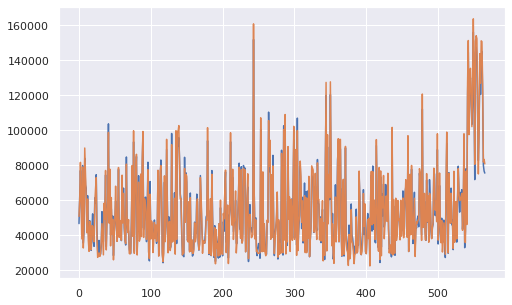

In [ ]:
gb_reg = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=25,
    max_leaf_nodes=50,
    random_state=0,
    verbose=0,
    warm_start=False,
)
cv = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)


poisson_scores = []
mape_scores = []

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
    gb_reg.fit(df_x.iloc[train].values, df_y.iloc[train]["A_MEDIAN"].values)
    
    train_score = gb_reg.score(df_x.iloc[train].values, df_y.iloc[train]["A_MEDIAN"].values)
    test_score = gb_reg.score(df_x.iloc[test].values, df_y.iloc[test]["A_MEDIAN"].values)
    poisson_scores.append((train_score, test_score))


    y_pred = gb_reg.predict(df_x.iloc[train].values)
    train_score = mean_absolute_percentage_error(df_y.iloc[train]["A_MEDIAN"].values, y_pred)
    
    y_pred = gb_reg.predict(df_x.iloc[test].values)
    test_score = mean_absolute_percentage_error(df_y.iloc[test]["A_MEDIAN"].values, y_pred)
    mape_scores.append((train_score, test_score))


print(poisson_scores)
print(mape_scores)

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
  y_pred = gb_reg.predict(df_x.iloc[test].values)
  y_true = df_y.iloc[test]["A_MEDIAN"].values
  break

plt.plot(range(len(y_pred)), y_pred, label="pred")
plt.plot(range(len(y_true)), y_true, label="true")

**Observations**
1. GBM gives a MAPE loss of 13% compared to 22% of Random Forest and 11% of DNN.
2. Maybe GBM is overfitting. (I can't be sure as we do not have the training history over time in this case)

### Hyperparameter tuning

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


[(0.985576934107487, 0.8001743705130904), (0.9853085963103321, 0.8215246196417896), (0.9864237541586905, 0.800931632365812), (0.9856274822512668, 0.7979936231829875)]
[(0.05095448503780361, 0.12744186256009188), (0.05119137791290031, 0.12920569470827725), (0.050046472261416584, 0.12679310025777188), (0.05096179714312406, 0.1299176715146227)]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


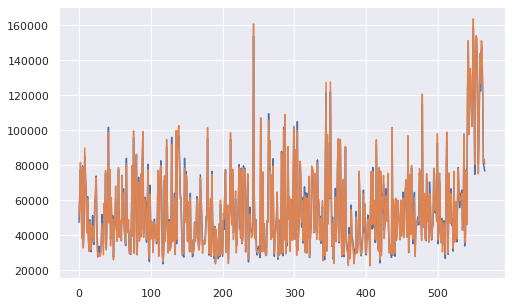

In [ ]:
# let's try to optimize the model by trying out different params

# increase number of estimators
gb_reg = GradientBoostingRegressor(
    n_estimators=150,
    max_depth=25,
    max_leaf_nodes=50,
    random_state=0,
    verbose=0,
    warm_start=False,
)
cv = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)


poisson_scores = []
mape_scores = []

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
    gb_reg.fit(df_x.iloc[train].values, df_y.iloc[train]["A_MEDIAN"].values)
    
    train_score = gb_reg.score(df_x.iloc[train].values, df_y.iloc[train]["A_MEDIAN"].values)
    test_score = gb_reg.score(df_x.iloc[test].values, df_y.iloc[test]["A_MEDIAN"].values)
    poisson_scores.append((train_score, test_score))


    y_pred = gb_reg.predict(df_x.iloc[train].values)
    train_score = mean_absolute_percentage_error(df_y.iloc[train]["A_MEDIAN"].values, y_pred)
    
    y_pred = gb_reg.predict(df_x.iloc[test].values)
    test_score = mean_absolute_percentage_error(df_y.iloc[test]["A_MEDIAN"].values, y_pred)
    mape_scores.append((train_score, test_score))


print(poisson_scores)
print(mape_scores)

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
  y_pred = gb_reg.predict(df_x.iloc[test].values)
  y_true = df_y.iloc[test]["A_MEDIAN"].values
  break

plt.plot(range(len(y_pred)), y_pred, label="pred")
plt.plot(range(len(y_true)), y_true, label="true")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


[(0.9309849542749752, 0.7699229622563084), (0.9297641338414482, 0.7865742501927202), (0.9305394752866181, 0.7791596396505185), (0.9330756993317708, 0.7686485962525436)]
[(0.10593755465268118, 0.14975214681233184), (0.1047706246040192, 0.15669707439610658), (0.10658542700050776, 0.146769699172622), (0.104844276766383, 0.14783302718441899)]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


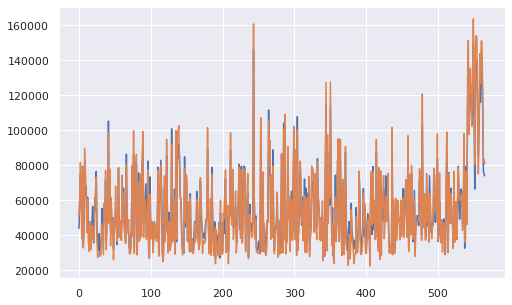

In [ ]:
# decrease number of estimators
gb_reg = GradientBoostingRegressor(
    n_estimators=50,
    max_depth=25,
    max_leaf_nodes=50,
    random_state=0,
    verbose=0,
    warm_start=False,
)
cv = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)


poisson_scores = []
mape_scores = []

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
    gb_reg.fit(df_x.iloc[train].values, df_y.iloc[train]["A_MEDIAN"].values)
    
    train_score = gb_reg.score(df_x.iloc[train].values, df_y.iloc[train]["A_MEDIAN"].values)
    test_score = gb_reg.score(df_x.iloc[test].values, df_y.iloc[test]["A_MEDIAN"].values)
    poisson_scores.append((train_score, test_score))


    y_pred = gb_reg.predict(df_x.iloc[train].values)
    train_score = mean_absolute_percentage_error(df_y.iloc[train]["A_MEDIAN"].values, y_pred)
    
    y_pred = gb_reg.predict(df_x.iloc[test].values)
    test_score = mean_absolute_percentage_error(df_y.iloc[test]["A_MEDIAN"].values, y_pred)
    mape_scores.append((train_score, test_score))


print(poisson_scores)
print(mape_scores)

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
  y_pred = gb_reg.predict(df_x.iloc[test].values)
  y_true = df_y.iloc[test]["A_MEDIAN"].values
  break

plt.plot(range(len(y_pred)), y_pred, label="pred")
plt.plot(range(len(y_true)), y_true, label="true")

I have tried several different values for parameters and observed the output. Just demonstrating two of them here.

NOTE: I haven't used GridSearch for this. It would be easy but I do not think it is required as the main purpose here to find out which model suits best and why, instead of creating a production ready highly optimal system.

### Adding new features

In [ ]:
# data setup
non_target_cols = [col for col in df_new.columns if "A_" not in col]

df_x = pd.concat([df_dummies.copy().reset_index(drop=True), df_new[non_target_cols].reset_index(drop=True)], axis=1)
df_x

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,occ_med_50,occ_max_50,occ_min_75,occ_avg_75,occ_med_75,occ_max_75,occ_min_90,occ_avg_90,occ_med_90,occ_max_90
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,54830.0,94320.0,49890.0,70220.0,70820.0,102160.0,63120.0,86237.272727,82240.0,123940.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,63810.0,87810.0,76740.0,94386.153846,97630.0,121910.0,97360.0,124499.230769,129960.0,163790.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,79440.0,89740.0,94570.0,110778.888889,112380.0,126320.0,119650.0,145735.555556,149070.0,166550.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,76600.0,160800.0,61960.0,95946.428571,97850.0,162980.0,98690.0,121911.428571,122980.0,181100.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70000.0,81770.0,60100.0,85207.142857,89115.0,106640.0,77480.0,106948.571429,109520.0,133180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,80850.0,170690.0,80750.0,141450.45614,133210.0,222518.0,118280.0,193849.027569,191180.0,274916.571429
2257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,80850.0,170690.0,80750.0,141450.45614,133210.0,222518.0,118280.0,193849.027569,191180.0,274916.571429
2258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,80850.0,170690.0,80750.0,141450.45614,133210.0,222518.0,118280.0,193849.027569,191180.0,274916.571429
2259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,80850.0,170690.0,80750.0,141450.45614,133210.0,222518.0,118280.0,193849.027569,191180.0,274916.571429


In [ ]:
df_y = df_train_filled[[col for col in df_train_filled.columns if "A_" in col]]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


[(0.9917716541052802, 0.8561024874644177), (0.9907830486846098, 0.8487043417331842), (0.9913113700524785, 0.8473644543636492), (0.9917305279326614, 0.8486924156479853)]
[(0.03676056011441967, 0.10154694348229058), (0.03762873185235228, 0.11124317257270507), (0.03735424960250517, 0.1026095157158583), (0.03639344373072534, 0.10724385991930016)]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


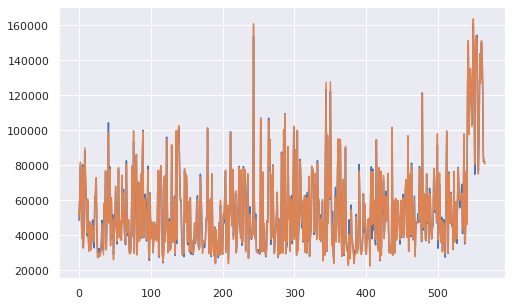

In [ ]:
gb_reg = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=25,
    max_leaf_nodes=50,
    random_state=0,
    verbose=0,
    warm_start=False,
)
cv = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)


poisson_scores = []
mape_scores = []

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
    gb_reg.fit(df_x.iloc[train].values, df_y.iloc[train]["A_MEDIAN"].values)
    
    train_score = gb_reg.score(df_x.iloc[train].values, df_y.iloc[train]["A_MEDIAN"].values)
    test_score = gb_reg.score(df_x.iloc[test].values, df_y.iloc[test]["A_MEDIAN"].values)
    poisson_scores.append((train_score, test_score))


    y_pred = gb_reg.predict(df_x.iloc[train].values)
    train_score = mean_absolute_percentage_error(df_y.iloc[train]["A_MEDIAN"].values, y_pred)
    
    y_pred = gb_reg.predict(df_x.iloc[test].values)
    test_score = mean_absolute_percentage_error(df_y.iloc[test]["A_MEDIAN"].values, y_pred)
    mape_scores.append((train_score, test_score))


print(poisson_scores)
print(mape_scores)

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
  y_pred = gb_reg.predict(df_x.iloc[test].values)
  y_true = df_y.iloc[test]["A_MEDIAN"].values
  break

plt.plot(range(len(y_pred)), y_pred, label="pred")
plt.plot(range(len(y_true)), y_true, label="true")

**Observations**
1. Loss reduced from 13% to 11%. New features helped.

From the above observations, we select GBM as our final model.

## Incorporating order of targets in models 

### Training & Evaluation

In [ ]:
# data setup
non_target_cols = [col for col in df_new.columns if "A_" not in col]

df_x = pd.concat([df_dummies.copy().reset_index(drop=True), df_new[non_target_cols].reset_index(drop=True)], axis=1)

df_y = df_train_filled[[col for col in df_train_filled.columns if "A_" in col]]
df_x.shape

(2261, 249)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


[(0.98660139057337, 0.8313052715926377), (0.9860133823186611, 0.7810265173869687), (0.9861501390915276, 0.8069256135561375), (0.9874078468489011, 0.7879980767557824)]
[(0.034149579858418246, 0.09612056101385308), (0.034447939310673276, 0.09857812639828108), (0.03555406072527648, 0.08949279644587378), (0.03295696107449124, 0.10027320627982068)]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


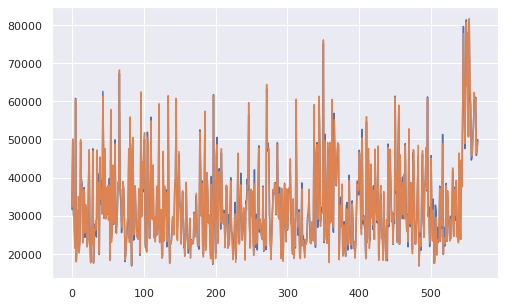

In [ ]:
# for PCT 10

gb_reg_10 = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=25,
    max_leaf_nodes=50,
    random_state=0,
    verbose=0,
    warm_start=False,
)
cv = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)


poisson_scores = []
mape_scores = []

for (train, test) in cv.split(df_x, df_y["A_PCT10"]):
    gb_reg_10.fit(df_x.iloc[train].values, df_y.iloc[train]["A_PCT10"].values)
    
    train_score = gb_reg_10.score(df_x.iloc[train].values, df_y.iloc[train]["A_PCT10"].values)
    test_score = gb_reg_10.score(df_x.iloc[test].values, df_y.iloc[test]["A_PCT10"].values)
    poisson_scores.append((train_score, test_score))


    y_pred = gb_reg_10.predict(df_x.iloc[train].values)
    train_score = mean_absolute_percentage_error(df_y.iloc[train]["A_PCT10"].values, y_pred)
    
    y_pred = gb_reg_10.predict(df_x.iloc[test].values)
    test_score = mean_absolute_percentage_error(df_y.iloc[test]["A_PCT10"].values, y_pred)
    mape_scores.append((train_score, test_score))


print(poisson_scores)
print(mape_scores)

for (train, test) in cv.split(df_x, df_y["A_PCT10"]):
  y_pred = gb_reg_10.predict(df_x.iloc[test].values)
  y_true = df_y.iloc[test]["A_PCT10"].values
  break

plt.plot(range(len(y_pred)), y_pred, label="pred")
plt.plot(range(len(y_true)), y_true, label="true")

In [ ]:
# add prediction of gb_reg_10 as a feature for PCT25

df_x["gb_reg_10"] = gb_reg_10.predict(df_x.values)
df_x["gb_reg_10"]

0       31676.441756
1       40209.788308
2       57221.481379
3       37681.892108
4       49137.993635
            ...     
2256    49981.528380
2257    51213.722928
2258    48442.324867
2259    46561.983960
2260    37320.715807
Name: gb_reg_10, Length: 2261, dtype: float64

In [ ]:
# a utility function used for output refinement

def refine(curr_target, prev_target, diff):
  filter = (curr_target < prev_target)
  curr_target[filter] = prev_target[filter] + diff
  return curr_target

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


[(0.02684988387744592, 0.07879174214546968), (0.028126685767529965, 0.07531207607465172), (0.02656309290937055, 0.08010312616980075), (0.028405479070720312, 0.07534297185575282)]
0.028178815305912572


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


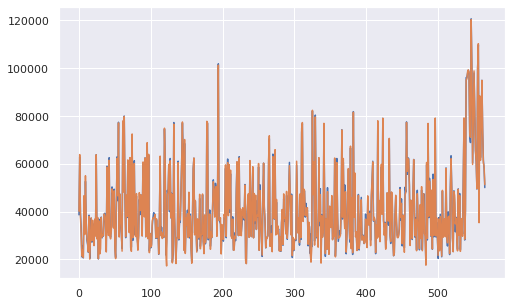

In [ ]:
# for pct25

gb_reg_25 = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=25,
    max_leaf_nodes=50,
    random_state=0,
    verbose=0,
    warm_start=False,
)
cv = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)


mape_scores = []
diff_25 = 0

for (train, test) in cv.split(df_x, df_y["A_PCT25"]):
    # calculate diff
    diff_25 = (df_y.iloc[train]["A_PCT25"] - df_y.iloc[train]["A_PCT10"]).mean()

    
    gb_reg_25.fit(df_x.iloc[train].values, df_y.iloc[train]["A_PCT25"].values)
    
    y_pred = gb_reg_25.predict(df_x.iloc[train].values)
    # refine pred
    y_pred = refine(y_pred, df_x.iloc[train]["gb_reg_10"].values, diff_25)
    train_score = mean_absolute_percentage_error(df_y.iloc[train]["A_PCT25"].values, y_pred)
    
    y_pred = gb_reg_25.predict(df_x.iloc[test].values)
    # refine pred
    y_pred = refine(y_pred, df_x.iloc[test]["gb_reg_10"].values, diff_25)
    test_score = mean_absolute_percentage_error(df_y.iloc[test]["A_PCT25"].values, y_pred)
    mape_scores.append((train_score, test_score))


print(mape_scores)

for (train, test) in cv.split(df_x, df_y["A_PCT25"]):
  y_pred = gb_reg_25.predict(df_x.iloc[test].values)
  # refine pred
  y_pred = refine(y_pred, df_x.iloc[test]["gb_reg_10"].values, diff_25)
  
  y_true = df_y.iloc[test]["A_PCT25"].values
  print(mean_absolute_percentage_error(y_true, y_pred))
  break

plt.plot(range(len(y_pred)), y_pred, label="pred")
plt.plot(range(len(y_true)), y_true, label="true")

In [ ]:
# check that the order between targets was maintained

df_x["gb_reg_25"] = gb_reg_25.predict(df_x.values)
# refine pred
df_x.loc[:, "gb_reg_25"] = refine(df_x["gb_reg_25"].values, df_x["gb_reg_10"].values, diff_25)
((df_x["gb_reg_25"] > df_x["gb_reg_10"]).sum()) / len(df_x["gb_reg_25"])

1.0

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


[(0.027722742540433748, 0.07685563116838362), (0.02660607890905408, 0.07439254317585962), (0.02598280678463309, 0.07753368588274187), (0.026717215775095504, 0.07550546574066666)]
0.024363717356330156


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


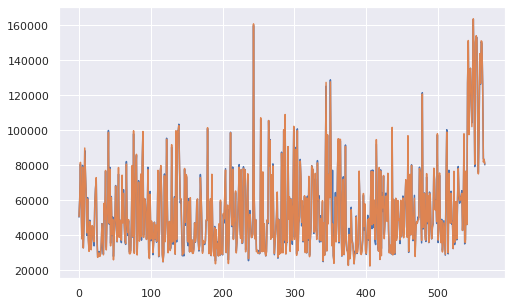

In [ ]:
# for median


gb_reg_50 = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=25,
    max_leaf_nodes=50,
    random_state=0,
    verbose=0,
    warm_start=False,
)
cv = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)


mape_scores = []
diff_50 = 0

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
    # calculate diff
    diff_50 = (df_y.iloc[train]["A_MEDIAN"] - df_y.iloc[train]["A_PCT25"]).mean()

    
    gb_reg_50.fit(df_x.iloc[train].values, df_y.iloc[train]["A_MEDIAN"].values)
    
    y_pred = gb_reg_50.predict(df_x.iloc[train].values)
    # refine pred
    y_pred = refine(y_pred, df_x.iloc[train]["gb_reg_25"].values, diff_50)
    train_score = mean_absolute_percentage_error(df_y.iloc[train]["A_MEDIAN"].values, y_pred)
    
    y_pred = gb_reg_50.predict(df_x.iloc[test].values)
    # refine pred
    y_pred = refine(y_pred, df_x.iloc[test]["gb_reg_25"].values, diff_50)
    test_score = mean_absolute_percentage_error(df_y.iloc[test]["A_MEDIAN"].values, y_pred)
    mape_scores.append((train_score, test_score))


print(mape_scores)

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
  y_pred = gb_reg_50.predict(df_x.iloc[test].values)
  # refine pred
  y_pred = refine(y_pred, df_x.iloc[test]["gb_reg_25"].values, diff_50)
  
  y_true = df_y.iloc[test]["A_MEDIAN"].values
  print(mean_absolute_percentage_error(y_true, y_pred))
  break

plt.plot(range(len(y_pred)), y_pred, label="pred")
plt.plot(range(len(y_true)), y_true, label="true")

In [ ]:
# check that the order between targets was maintained

df_x["gb_reg_50"] = gb_reg_50.predict(df_x.values)
# refine pred
df_x.loc[:, "gb_reg_50"] = refine(df_x["gb_reg_50"].values, df_x["gb_reg_25"].values, diff_50)
((df_x["gb_reg_50"] > df_x["gb_reg_25"]).sum()) / len(df_x["gb_reg_50"])

1.0

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


[(0.020701162023536605, 0.06837431159149197), (0.021048235689219617, 0.07364294597467867), (0.02073059317182416, 0.07067613782573658), (0.017921472656909056, 0.09437728417102698)]
0.01724460572295558


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


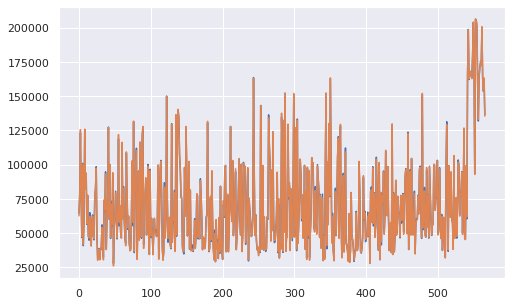

In [ ]:
# for pct75


gb_reg_75 = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=25,
    max_leaf_nodes=50,
    random_state=0,
    verbose=0,
    warm_start=False,
)
cv = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)


mape_scores = []
diff_75 = 0

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
    # calculate diff
    diff_75 = (df_y.iloc[train]["A_PCT75"] - df_y.iloc[train]["A_MEDIAN"]).mean()

    
    gb_reg_75.fit(df_x.iloc[train].values, df_y.iloc[train]["A_PCT75"].values)
    
    y_pred = gb_reg_75.predict(df_x.iloc[train].values)
    # refine pred
    y_pred = refine(y_pred, df_x.iloc[train]["gb_reg_25"].values, diff_75)
    train_score = mean_absolute_percentage_error(df_y.iloc[train]["A_PCT75"].values, y_pred)
    
    y_pred = gb_reg_75.predict(df_x.iloc[test].values)
    # refine pred
    y_pred = refine(y_pred, df_x.iloc[test]["gb_reg_25"].values, diff_75)
    test_score = mean_absolute_percentage_error(df_y.iloc[test]["A_PCT75"].values, y_pred)
    mape_scores.append((train_score, test_score))


print(mape_scores)

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
  y_pred = gb_reg_75.predict(df_x.iloc[test].values)
  # refine pred
  y_pred = refine(y_pred, df_x.iloc[test]["gb_reg_25"].values, diff_75)
  
  y_true = df_y.iloc[test]["A_PCT75"].values
  print(mean_absolute_percentage_error(y_true, y_pred))
  break

plt.plot(range(len(y_pred)), y_pred, label="pred")
plt.plot(range(len(y_true)), y_true, label="true")

In [ ]:
# check that the order between targets was maintained

df_x["gb_reg_75"] = gb_reg_75.predict(df_x.values)
# refine pred
df_x.loc[:, "gb_reg_75"] = refine(df_x["gb_reg_75"].values, df_x["gb_reg_50"].values, diff_75)
((df_x["gb_reg_75"] > df_x["gb_reg_50"]).sum()) / len(df_x["gb_reg_75"])

1.0

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


[(0.025216216488465993, 0.07099998784249167), (0.023587844447823306, 0.07373956918183766), (0.023791013876076916, 0.07952132677207274), (0.019465610428112838, 0.1082458809203641)]
0.01758974298968837


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  UserWarning,


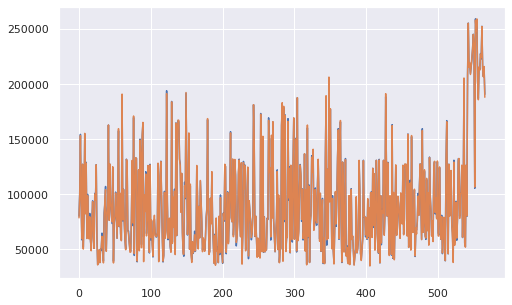

In [ ]:
# for pct90


gb_reg_90 = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=25,
    max_leaf_nodes=50,
    random_state=0,
    verbose=0,
    warm_start=False,
)
cv = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)


mape_scores = []
diff_90 = 0

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
    # calculate diff
    diff_90 = (df_y.iloc[train]["A_PCT90"] - df_y.iloc[train]["A_PCT75"]).mean()

    
    gb_reg_90.fit(df_x.iloc[train].values, df_y.iloc[train]["A_PCT90"].values)
    
    y_pred = gb_reg_90.predict(df_x.iloc[train].values)
    # refine pred
    y_pred = refine(y_pred, df_x.iloc[train]["gb_reg_50"].values, diff_90)
    train_score = mean_absolute_percentage_error(df_y.iloc[train]["A_PCT90"].values, y_pred)
    
    y_pred = gb_reg_90.predict(df_x.iloc[test].values)
    # refine pred
    y_pred = refine(y_pred, df_x.iloc[test]["gb_reg_50"].values, diff_90)
    test_score = mean_absolute_percentage_error(df_y.iloc[test]["A_PCT90"].values, y_pred)
    mape_scores.append((train_score, test_score))


print(mape_scores)

for (train, test) in cv.split(df_x, df_y["A_MEDIAN"]):
  y_pred = gb_reg_90.predict(df_x.iloc[test].values)
  # refine pred
  y_pred = refine(y_pred, df_x.iloc[test]["gb_reg_50"].values, diff_90)
  
  y_true = df_y.iloc[test]["A_PCT90"].values
  print(mean_absolute_percentage_error(y_true, y_pred))
  break

plt.plot(range(len(y_pred)), y_pred, label="pred")
plt.plot(range(len(y_true)), y_true, label="true")

In [ ]:
# check that the order between targets was maintained

df_x["gb_reg_90"] = gb_reg_90.predict(df_x.values)
# refine pred
df_x.loc[:, "gb_reg_90"] = refine(df_x["gb_reg_90"].values, df_x["gb_reg_75"].values, diff_90)
((df_x["gb_reg_90"] > df_x["gb_reg_50"]).sum()) / len(df_x["gb_reg_90"])

1.0

### Final Score - Mean Absolute Weighted Percentage Error

In [ ]:
# let's calculate the final score for gbm as defined in the task

# df_x is populated.. we will need to remove columns on need for every model
df_x

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,occ_max_75,occ_min_90,occ_avg_90,occ_med_90,occ_max_90,gb_reg_10,gb_reg_25,gb_reg_50,gb_reg_75,gb_reg_90
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,102160.0,63120.0,86237.272727,82240.0,123940.0,31676.441756,38668.682835,50448.493006,64523.956600,80115.039184
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,121910.0,97360.0,124499.230769,129960.0,163790.0,40209.788308,61530.466115,85152.915896,109896.852607,151266.748977
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,126320.0,119650.0,145735.555556,149070.0,166550.0,57221.481379,63591.687991,88782.975720,125701.932889,150756.746143
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,162980.0,98690.0,121911.428571,122980.0,181100.0,37681.892108,47581.805513,60896.780911,78239.355308,100949.366702
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,106640.0,77480.0,106948.571429,109520.0,133180.0,49137.993635,62820.574191,80606.447499,103591.700582,131659.406518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,222518.0,118280.0,193849.027569,191180.0,274916.571429,49981.528380,63761.971146,99416.533359,158300.452238,209992.250600
2257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,222518.0,118280.0,193849.027569,191180.0,274916.571429,51213.722928,74306.030786,102375.689421,164142.116434,215080.948442
2258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,222518.0,118280.0,193849.027569,191180.0,274916.571429,48442.324867,71017.015026,124240.800857,176864.011020,230198.819354
2259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,222518.0,118280.0,193849.027569,191180.0,274916.571429,46561.983960,61290.673674,92549.011852,149714.291156,196907.554520


In [ ]:
def normalized_absolute_error(true, pred):
    return abs(pred - true) / true


pred_10 = gb_reg_10.predict(df_x.iloc[:, :-5].values)

pred_25 = gb_reg_25.predict(df_x.iloc[:, :-4].values)
pred_25 = refine(pred_25, pred_10, diff_25)

pred_50 = gb_reg_50.predict(df_x.iloc[:, :-3].values)
pred_50 = refine(pred_50, pred_25, diff_50)

pred_75 = gb_reg_75.predict(df_x.iloc[:, :-2].values)
pred_75 = refine(pred_75, pred_50, diff_75)

pred_90 = gb_reg_90.predict(df_x.iloc[:, :-1].values)
pred_90 = refine(pred_90, pred_75, diff_90)

In [ ]:
# check
((pred_10 < pred_25) & (pred_25 < pred_50) & (pred_50 < pred_75) & (pred_75 < pred_90)).all()

True

In [ ]:
# weighted error calcluation
l10 = 0.1*normalized_absolute_error(df_y["A_PCT10"].values, pred_10)
l25 = 0.2*normalized_absolute_error(df_y["A_PCT25"].values, pred_25)
l50 = 0.4*normalized_absolute_error(df_y["A_MEDIAN"].values, pred_50)
l75 = 0.2*normalized_absolute_error(df_y["A_PCT75"].values, pred_75)
l90 = 0.1*normalized_absolute_error(df_y["A_PCT90"].values, pred_90)

In [ ]:
# final score
(l10+l25+l50+l75+l90).mean()

0.04152798994513433

## Prediction

### Data Preparation

In [ ]:
# load inference data

df_infer = pd.read_csv("submission.csv")
df_infer

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,Accommodation and Food Services,Other Production Occupations,10000,20000,30000,40000,50000
1,NE,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000
2,US,Manufacturing,Construction and Extraction Occupations,10000,20000,30000,40000,50000
3,US,Wholesale Trade,Material Moving Workers,10000,20000,30000,40000,50000
4,US,Other Services (except Public Administration),Supervisors of Building and Grounds Cleaning a...,10000,20000,30000,40000,50000
...,...,...,...,...,...,...,...,...
921,US,Utilities,Other Educational Instruction and Library Occu...,10000,20000,30000,40000,50000
922,US,"Arts, Entertainment, and Recreation",Community and Social Service Occupations,10000,20000,30000,40000,50000
923,WI,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000
924,PA,Cross-industry,Computer and Mathematical Occupations,10000,20000,30000,40000,50000


In [ ]:
# create features using pre-trained one hot encoder
feature_arr = ohe.transform(df_infer[["PRIM_STATE", "NAICS_TITLE", "OCC_TITLE"]]).toarray()
feature_labels = ohe.categories_

df_dummies_infer = pd.DataFrame(feature_arr, columns=feature_labels[0].tolist() + feature_labels[1].tolist() + feature_labels[2].tolist())
df_dummies_infer

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,Supervisors of Protective Service Workers,Supervisors of Sales Workers,Supervisors of Transportation and Material Moving Workers,"Textile, Apparel, and Furnishings Workers",Top Executives,Tour and Travel Guides,Transportation and Material Moving Occupations,"Vehicle and Mobile Equipment Mechanics, Installers, and Repairers",Water Transportation Workers,Woodworkers
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_new_infer = df_infer.copy()
df_new_infer

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,Accommodation and Food Services,Other Production Occupations,10000,20000,30000,40000,50000
1,NE,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000
2,US,Manufacturing,Construction and Extraction Occupations,10000,20000,30000,40000,50000
3,US,Wholesale Trade,Material Moving Workers,10000,20000,30000,40000,50000
4,US,Other Services (except Public Administration),Supervisors of Building and Grounds Cleaning a...,10000,20000,30000,40000,50000
...,...,...,...,...,...,...,...,...
921,US,Utilities,Other Educational Instruction and Library Occu...,10000,20000,30000,40000,50000
922,US,"Arts, Entertainment, and Recreation",Community and Social Service Occupations,10000,20000,30000,40000,50000
923,WI,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000
924,PA,Cross-industry,Computer and Mathematical Occupations,10000,20000,30000,40000,50000


In [ ]:
# adding feature columns

df_state_final = df_state_final.add_prefix("state_")
df_naics_final = df_naics_final.add_prefix("naics_")
df_occ_final = df_occ_final.add_prefix("occ_")

# adding feature columns
df_new_infer.loc[:, df_state_final.columns] = None
df_new_infer.loc[:, df_naics_final.columns] = None
df_new_infer.loc[:, df_occ_final.columns] = None
df_new_infer.head()

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,state_min_10,state_avg_10,...,occ_med_50,occ_max_50,occ_min_75,occ_avg_75,occ_med_75,occ_max_75,occ_min_90,occ_avg_90,occ_med_90,occ_max_90
0,US,Accommodation and Food Services,Other Production Occupations,10000,20000,30000,40000,50000,None,None,...,None,None,None,None,None,None,None,None,None,None
1,NE,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000,None,None,...,None,None,None,None,None,None,None,None,None,None
2,US,Manufacturing,Construction and Extraction Occupations,10000,20000,30000,40000,50000,None,None,...,None,None,None,None,None,None,None,None,None,None
3,US,Wholesale Trade,Material Moving Workers,10000,20000,30000,40000,50000,None,None,...,None,None,None,None,None,None,None,None,None,None
4,US,Other Services (except Public Administration),Supervisors of Building and Grounds Cleaning a...,10000,20000,30000,40000,50000,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
# now, let's add these features into the dataframe
for state in df_state_final.index:
  df_new_infer.loc[df_new_infer["PRIM_STATE"] == state, [col for col in df_new_infer.columns if "state_" in col]] = df_state_final.loc[state].tolist()

for naics in df_naics_final.index:
  df_new_infer.loc[df_new_infer["NAICS_TITLE"] == naics, [col for col in df_new_infer.columns if "naics_" in col]] = df_naics_final.loc[naics].tolist()

for occ in df_occ_final.index:
  df_new_infer.loc[df_new_infer["OCC_TITLE"] == occ, [col for col in df_new_infer.columns if "occ_" in col]] = df_occ_final.loc[occ].tolist()


df_new_infer.isna().any().any()

False

In [ ]:
df_new_infer

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,state_min_10,state_avg_10,...,occ_med_50,occ_max_50,occ_min_75,occ_avg_75,occ_med_75,occ_max_75,occ_min_90,occ_avg_90,occ_med_90,occ_max_90
0,US,Accommodation and Food Services,Other Production Occupations,10000,20000,30000,40000,50000,17290.0,34364.805195,...,39400.0,78640.0,35960.0,54728.888889,49950.0,92870.0,38370.0,68005.0,71265.0,98540.0
1,NE,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000,22960.0,33892.5,...,48340.0,94690.0,45460.0,71941.875,64830.0,124430.0,61770.0,99446.666667,98165.0,163700.0
2,US,Manufacturing,Construction and Extraction Occupations,10000,20000,30000,40000,50000,17290.0,34364.805195,...,48015.0,78210.0,48060.0,65420.6,61285.0,98070.0,61360.0,83458.6,78640.0,144140.0
3,US,Wholesale Trade,Material Moving Workers,10000,20000,30000,40000,50000,17290.0,34364.805195,...,33740.0,43200.0,36940.0,43518.75,40620.0,59910.0,45760.0,55510.0,48460.0,78390.0
4,US,Other Services (except Public Administration),Supervisors of Building and Grounds Cleaning a...,10000,20000,30000,40000,50000,17290.0,34364.805195,...,48950.0,61720.0,48520.0,63349.090909,61790.0,78320.0,63310.0,76607.272727,77880.0,86040.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,US,Utilities,Other Educational Instruction and Library Occu...,10000,20000,30000,40000,50000,17290.0,34364.805195,...,35340.0,76600.0,30420.0,57826.363636,48570.0,98070.0,37660.0,80877.272727,78160.0,121350.0
922,US,"Arts, Entertainment, and Recreation",Community and Social Service Occupations,10000,20000,30000,40000,50000,17290.0,34364.805195,...,47775.0,115350.0,47600.0,63929.166667,61235.0,126090.0,59850.0,78759.791667,77360.0,129470.0
923,WI,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000,17790.0,30012.142857,...,48340.0,94690.0,45460.0,71941.875,64830.0,124430.0,61770.0,99446.666667,98165.0,163700.0
924,PA,Cross-industry,Computer and Mathematical Occupations,10000,20000,30000,40000,50000,17800.0,30170.0,...,79860.0,127370.0,77760.0,113602.264151,106190.0,162000.0,99340.0,141548.490566,134070.0,197870.0


In [ ]:
# let's drop the raw features now
df_new_infer.drop(columns=["PRIM_STATE", "NAICS_TITLE", "OCC_TITLE"], inplace=True)
df_new_infer.columns

Index(['A_PCT10', 'A_PCT25', 'A_MEDIAN', 'A_PCT75', 'A_PCT90', 'state_min_10',
       'state_avg_10', 'state_med_10', 'state_max_10', 'state_min_25',
       'state_avg_25', 'state_med_25', 'state_max_25', 'state_min_50',
       'state_avg_50', 'state_med_50', 'state_max_50', 'state_min_75',
       'state_avg_75', 'state_med_75', 'state_max_75', 'state_min_90',
       'state_avg_90', 'state_med_90', 'state_max_90', 'naics_min_10',
       'naics_avg_10', 'naics_med_10', 'naics_max_10', 'naics_min_25',
       'naics_avg_25', 'naics_med_25', 'naics_max_25', 'naics_min_50',
       'naics_avg_50', 'naics_med_50', 'naics_max_50', 'naics_min_75',
       'naics_avg_75', 'naics_med_75', 'naics_max_75', 'naics_min_90',
       'naics_avg_90', 'naics_med_90', 'naics_max_90', 'occ_min_10',
       'occ_avg_10', 'occ_med_10', 'occ_max_10', 'occ_min_25', 'occ_avg_25',
       'occ_med_25', 'occ_max_25', 'occ_min_50', 'occ_avg_50', 'occ_med_50',
       'occ_max_50', 'occ_min_75', 'occ_avg_75', 'occ_med_7

In [ ]:
# prepare final data
non_target_cols = [col for col in df_new_infer.columns if "A_" not in col]

df_x = pd.concat([df_dummies_infer.copy().reset_index(drop=True), df_new_infer[non_target_cols].reset_index(drop=True)], axis=1)

df_y = df_infer[[col for col in df_infer.columns if "A_" in col]]

In [ ]:
df_x

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,occ_med_50,occ_max_50,occ_min_75,occ_avg_75,occ_med_75,occ_max_75,occ_min_90,occ_avg_90,occ_med_90,occ_max_90
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39400.0,78640.0,35960.0,54728.888889,49950.0,92870.0,38370.0,68005.0,71265.0,98540.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48340.0,94690.0,45460.0,71941.875,64830.0,124430.0,61770.0,99446.666667,98165.0,163700.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48015.0,78210.0,48060.0,65420.6,61285.0,98070.0,61360.0,83458.6,78640.0,144140.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33740.0,43200.0,36940.0,43518.75,40620.0,59910.0,45760.0,55510.0,48460.0,78390.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48950.0,61720.0,48520.0,63349.090909,61790.0,78320.0,63310.0,76607.272727,77880.0,86040.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,35340.0,76600.0,30420.0,57826.363636,48570.0,98070.0,37660.0,80877.272727,78160.0,121350.0
922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,47775.0,115350.0,47600.0,63929.166667,61235.0,126090.0,59850.0,78759.791667,77360.0,129470.0
923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48340.0,94690.0,45460.0,71941.875,64830.0,124430.0,61770.0,99446.666667,98165.0,163700.0
924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,79860.0,127370.0,77760.0,113602.264151,106190.0,162000.0,99340.0,141548.490566,134070.0,197870.0


In [ ]:
df_y

,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,10000,20000,30000,40000,50000
1,10000,20000,30000,40000,50000
2,10000,20000,30000,40000,50000
3,10000,20000,30000,40000,50000
4,10000,20000,30000,40000,50000
...,...,...,...,...,...
921,10000,20000,30000,40000,50000
922,10000,20000,30000,40000,50000
923,10000,20000,30000,40000,50000
924,10000,20000,30000,40000,50000


### Predict

In [ ]:
pred_10 = gb_reg_10.predict(df_x.values)
df_x["pred_10"] = pred_10

pred_25 = gb_reg_25.predict(df_x.values)
pred_25 = refine(pred_25, pred_10, diff_25)
df_x["pred_25"] = pred_25

pred_50 = gb_reg_50.predict(df_x.values)
pred_50 = refine(pred_50, pred_25, diff_50)
df_x["pred_50"] = pred_50

pred_75 = gb_reg_75.predict(df_x.values)
pred_75 = refine(pred_75, pred_50, diff_75)
df_x["pred_75"] = pred_75

pred_90 = gb_reg_90.predict(df_x.values)
pred_90 = refine(pred_90, pred_75, diff_90)
df_x["pred_90"] = pred_90

In [ ]:
# check
((pred_10 < pred_25) & (pred_25 < pred_50) & (pred_50 < pred_75) & (pred_75 < pred_90)).all()

True

In [ ]:
df_x

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,occ_max_75,occ_min_90,occ_avg_90,occ_med_90,occ_max_90,pred_10,pred_25,pred_50,pred_75,pred_90
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,92870.0,38370.0,68005.0,71265.0,98540.0,22708.484433,30384.181957,33391.191535,40686.353314,53427.751737
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,124430.0,61770.0,99446.666667,98165.0,163700.0,28297.446847,35501.081306,49590.972852,71048.162449,91968.329034
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,98070.0,61360.0,83458.6,78640.0,144140.0,32336.272006,39933.611688,52526.525412,62294.423137,81899.929479
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,59910.0,45760.0,55510.0,48460.0,78390.0,25503.481705,28081.234414,33255.596778,39977.881109,51500.691632
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,78320.0,63310.0,76607.272727,77880.0,86040.0,33293.579491,38905.783904,46457.135304,60361.290460,76045.974766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,98070.0,37660.0,80877.272727,78160.0,121350.0,39071.054453,55982.733616,80416.947987,101627.011242,122370.138343
922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,126090.0,59850.0,78759.791667,77360.0,129470.0,27735.463163,33141.064688,41459.235704,55857.249833,76860.406920
923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,124430.0,61770.0,99446.666667,98165.0,163700.0,24917.629493,31802.630922,48139.414158,65433.753248,93848.082976
924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,162000.0,99340.0,141548.490566,134070.0,197870.0,43572.352052,60076.341248,80448.304683,109452.182579,145036.603660


### Save submission.csv

In [ ]:
df_infer

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,Accommodation and Food Services,Other Production Occupations,10000,20000,30000,40000,50000
1,NE,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000
2,US,Manufacturing,Construction and Extraction Occupations,10000,20000,30000,40000,50000
3,US,Wholesale Trade,Material Moving Workers,10000,20000,30000,40000,50000
4,US,Other Services (except Public Administration),Supervisors of Building and Grounds Cleaning a...,10000,20000,30000,40000,50000
...,...,...,...,...,...,...,...,...
921,US,Utilities,Other Educational Instruction and Library Occu...,10000,20000,30000,40000,50000
922,US,"Arts, Entertainment, and Recreation",Community and Social Service Occupations,10000,20000,30000,40000,50000
923,WI,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000
924,PA,Cross-industry,Computer and Mathematical Occupations,10000,20000,30000,40000,50000


In [ ]:
df_infer.loc[:, ["A_PCT10", "A_PCT25", "A_MEDIAN", "A_PCT75", "A_PCT90"]] = df_x[["pred_10", "pred_25", "pred_50", "pred_75", "pred_90"]].values
df_infer

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,Accommodation and Food Services,Other Production Occupations,22708.484433,30384.181957,33391.191535,40686.353314,53427.751737
1,NE,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",28297.446847,35501.081306,49590.972852,71048.162449,91968.329034
2,US,Manufacturing,Construction and Extraction Occupations,32336.272006,39933.611688,52526.525412,62294.423137,81899.929479
3,US,Wholesale Trade,Material Moving Workers,25503.481705,28081.234414,33255.596778,39977.881109,51500.691632
4,US,Other Services (except Public Administration),Supervisors of Building and Grounds Cleaning a...,33293.579491,38905.783904,46457.135304,60361.290460,76045.974766
...,...,...,...,...,...,...,...,...
921,US,Utilities,Other Educational Instruction and Library Occu...,39071.054453,55982.733616,80416.947987,101627.011242,122370.138343
922,US,"Arts, Entertainment, and Recreation",Community and Social Service Occupations,27735.463163,33141.064688,41459.235704,55857.249833,76860.406920
923,WI,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",24917.629493,31802.630922,48139.414158,65433.753248,93848.082976
924,PA,Cross-industry,Computer and Mathematical Occupations,43572.352052,60076.341248,80448.304683,109452.182579,145036.603660


In [ ]:
df_infer.isna().any()

PRIM_STATE     False
NAICS_TITLE    False
OCC_TITLE      False
A_PCT10        False
A_PCT25        False
A_MEDIAN       False
A_PCT75        False
A_PCT90        False
dtype: bool

In [ ]:
df_infer.to_csv("submission.csv", index=False)